In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random_state = 22

<b>Teknis Pengerjaan</b>
1. Pekerjaan dilakukan secara berkelompok, dengan output berupa:

    * File .ipynb yang berisi hasil analisis/modeling
    * Sebuah presentasi .pdf yang berisi ringkasan dari poin-poin penting yang dijabarkan pada slide-slide selanjutnya

2. Homework ini berupa soal clustering end-to-end pertanyaan bisnis dimana teman-teman akan diberikan sebuah dataset mentah berisi data customer. Teman-teman diharapkan melakukan 4 hal berikut dengan menggunakan dataset tersebut
    * EDA
    * Feature Engineering
    * Modeling + Evaluasi
    * Interpretasi model + Rekomendasi

3. Upload hasil pengerjaanmu melalui LMS dengan format nama file sebagai berikut
Nama_Lengkap_Batch_XX dalam format .html (cara save dalam format .html disini)

# Dataset
<b>Airline Customer Value Analysis Case</b>

Deskripsi:
Dataset ini berisi data customer sebuah perusahaan penerbangan dan
beberapa fitur yang dapat menggambarkan value dari customer
tersebut.

Data:
Setiap baris mewakili customer, setiap kolom berisi atribut customer.

[Link data](https://drive.google.com/drive/folders/1v7BjYPybGlhQ9oNiPwgA-1l1uh3Vi3yW)

In [3]:
raw_data = pd.read_csv('flight.csv', parse_dates=['FFP_DATE', 'FIRST_FLIGHT_DATE', 'LOAD_TIME', 'LAST_FLIGHT_DATE'])
df = raw_data.copy()
df.head()

MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER    WORK_CITY  \
0      54993 2006-11-02        2008-12-24   Male         6            .   
1      28065 2007-02-19        2007-08-03   Male         6          NaN   
2      55106 2007-02-01        2007-08-30   Male         6            .   
3      21189 2008-08-22        2008-08-23   Male         5  Los Angeles   
4      39546 2009-04-10        2009-04-15   Male         6      guiyang   

  WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  SUM_YR_2  SEG_KM_SUM  \
0       beijing           CN  31.0 2014-03-31  ...  234188.0      580717   
1       beijing           CN  42.0 2014-03-31  ...  167434.0      293678   
2       beijing           CN  40.0 2014-03-31  ...  164982.0      283712   
3            CA           US  64.0 2014-03-31  ...  125500.0      281336   
4       guizhou           CN  48.0 2014-03-31  ...  130702.0      309928   

   LAST_FLIGHT_DATE  LAST_TO_END  AVG_INTERVAL MAX_INTERVAL  EXCHANGE_COUNT  \
0         3/31/2014            1      3.483254           18              34   
1         3/25/2014            7      5.194245           17              29   
2         3/21/2014           11      5.298507           18              20   
3        12/26/2013           97     27.863636           73              11   
4         3/27/2014            5      4.788079           47              27   

   avg_discount  Points_Sum  Point_NotFlight  
0      0.961639      619760               50  
1      1.252314      415768               33  
2      1.254676      406361               26  
3      1.090870      372204               12  
4      0.970658      338813               39  

[5 rows x 23 columns]

In [4]:
# standardize column header to all lowercase to ease readability and processing
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   member_no          62988 non-null  int64         
 1   ffp_date           62988 non-null  datetime64[ns]
 2   first_flight_date  62988 non-null  datetime64[ns]
 3   gender             62985 non-null  object        
 4   ffp_tier           62988 non-null  int64         
 5   work_city          60719 non-null  object        
 6   work_province      59740 non-null  object        
 7   work_country       62962 non-null  object        
 8   age                62568 non-null  float64       
 9   load_time          62988 non-null  datetime64[ns]
 10  flight_count       62988 non-null  int64         
 11  bp_sum             62988 non-null  int64         
 12  sum_yr_1           62437 non-null  float64       
 13  sum_yr_2           62850 non-null  float64       
 14  seg_km

<b>Deskripsi Kolom</b> (dalam kapitalisasi original, sebelum diubah menjadi lower case)


* MEMBER_NO: ID Member
* FFP_DATE: Frequent Flyer Program Join Date
* FIRST_FLIGHT_DATE: Tanggal Penerbangan pertama
* GENDER: Jenis Kelamin
* FFP_TIER: Tier dari Frequent Flyer Program
* WORK_CITY: Kota Asal
* WORK_PROVINCE: Provinsi Asal
* WORK_COUNTRY: Negara Asal
* AGE: Umur Customer
* LOAD_TIME: Tanggal data diambil
* FLIGHT_COUNT: Jumlah penerbangan Customer
* BP_SUM: Rencana Perjalanan
* SUM_YR_1: Fare Revenue
* SUM_YR_2: Votes Prices
* SEG_KM_SUM: Total jarak(km) penerbangan yg sudah dilakukan
* LAST_FLIGHT_DATE: Tanggal penerbangan terakhir
* LAST_TO_END: Jarak waktu penerbangan terakhir ke pesanan penerbangan paling akhir
* AVG_INTERVAL: Rata-rata jarak waktu
* MAX_INTERVAL: Maksimal jarak waktu
* EXCHANGE_COUNT: Jumlah penukaran
* avg_discount: Rata rata discount yang didapat customer
* Points_Sum: Jumlah poin yang didapat customer
* Point_NotFlight: point yang tidak digunakan oleh members

Berdasarkan informasi di atas, dapat disimpulkan bahwa terdapat beberapa kolom yang memiliki data kosong, sehingga saat preprocessing perlu dilakukan handling untuk baris-baris yang memiliki data kosong tersebut.

Pada pembacaan data menggunakan `pd.read_csv`, beberapa kolom yang berbentuk tanggal langsung dibaca menjadi tipe data `datetime` menggunakan `parse_dates`, namun ada satu kolom yang tidak terbaca menjadi `datetime` yaitu kolom `last_flight_date`. Hal ini diduga diakibatkan oleh adanya beberapa data pada `last_flight_date` yang tidak berbentuk tanggal, sehingga perlu ditangani.



In [5]:
# convert last_flight_date to datetime
df['last_flight_date'] = pd.to_datetime(df['last_flight_date'], format='%m/%d/%y', errors='ignore')
df.head()

member_no   ffp_date first_flight_date gender  ffp_tier    work_city  \
0      54993 2006-11-02        2008-12-24   Male         6            .   
1      28065 2007-02-19        2007-08-03   Male         6          NaN   
2      55106 2007-02-01        2007-08-30   Male         6            .   
3      21189 2008-08-22        2008-08-23   Male         5  Los Angeles   
4      39546 2009-04-10        2009-04-15   Male         6      guiyang   

  work_province work_country   age  load_time  ...  sum_yr_2  seg_km_sum  \
0       beijing           CN  31.0 2014-03-31  ...  234188.0      580717   
1       beijing           CN  42.0 2014-03-31  ...  167434.0      293678   
2       beijing           CN  40.0 2014-03-31  ...  164982.0      283712   
3            CA           US  64.0 2014-03-31  ...  125500.0      281336   
4       guizhou           CN  48.0 2014-03-31  ...  130702.0      309928   

   last_flight_date  last_to_end  avg_interval max_interval  exchange_count  \
0         3/31/2014            1      3.483254           18              34   
1         3/25/2014            7      5.194245           17              29   
2         3/21/2014           11      5.298507           18              20   
3        12/26/2013           97     27.863636           73              11   
4         3/27/2014            5      4.788079           47              27   

   avg_discount  points_sum  point_notflight  
0      0.961639      619760               50  
1      1.252314      415768               33  
2      1.254676      406361               26  
3      1.090870      372204               12  
4      0.970658      338813               39  

[5 rows x 23 columns]

In [6]:
# check data type after conversion
print(df['last_flight_date'].dtypes)

object


Setelah melakukan konversi tipe data kolom `last_flight_date` menjadi `datetime`, masih ditemukan beberapa data yang tidak bisa dikonversi langsung. Data tersebut mungkin perlu dilihat dan ditangani secara manual.

In [7]:
# check unconverted data
df_err = df[pd.to_datetime(df['last_flight_date'], errors='coerce').isna()]
df_err['last_flight_date'].unique()

array(['2014/2/29  0:00:00'], dtype=object)

Berdasarkan info di atas, dapat dilihat bahwa terdapat satu tanggal yang bermasalah yaitu tanggal 2014/2/29. Tanggal tersebut tidak valid karena pada tahun 2014, Bulan Februari hanya memiliki 28 hari. Untuk saat ini, data akan diubah menjadi 2014/2/28.

In [8]:
# convert 29 Feb 2019 to 28 Feb 2014
df.loc[df['last_flight_date'] == '2014/2/29  0:00:00', 'last_flight_date'] = np.datetime64('2014-02-28')
df['last_flight_date'] = pd.to_datetime(df['last_flight_date'])

# recheck data type after conversion
print(df['last_flight_date'].dtypes)

datetime64[ns]


Setelah diperiksa ulang, saat ini kolom `last_flight_date` sudah berbentuk `datetime64`.

Jika setiap baris pada kolom `member_no` merupakan nilai unik, maka kolom tersebut tidak perlu digunakan dalam studi kasus ini dan dapat di drop. 

In [9]:
# check if member_no is all unique, if True then drop column
if df['member_no'].is_unique:
    df.drop('member_no', axis=1, inplace=True)

df.head()

ffp_date first_flight_date gender  ffp_tier    work_city work_province  \
0 2006-11-02        2008-12-24   Male         6            .       beijing   
1 2007-02-19        2007-08-03   Male         6          NaN       beijing   
2 2007-02-01        2007-08-30   Male         6            .       beijing   
3 2008-08-22        2008-08-23   Male         5  Los Angeles            CA   
4 2009-04-10        2009-04-15   Male         6      guiyang       guizhou   

  work_country   age  load_time  flight_count  ...  sum_yr_2  seg_km_sum  \
0           CN  31.0 2014-03-31           210  ...  234188.0      580717   
1           CN  42.0 2014-03-31           140  ...  167434.0      293678   
2           CN  40.0 2014-03-31           135  ...  164982.0      283712   
3           US  64.0 2014-03-31            23  ...  125500.0      281336   
4           CN  48.0 2014-03-31           152  ...  130702.0      309928   

   last_flight_date  last_to_end avg_interval  max_interval  exchange_count  \
0        2014-03-31            1     3.483254            18              34   
1        2014-03-25            7     5.194245            17              29   
2        2014-03-21           11     5.298507            18              20   
3        2013-12-26           97    27.863636            73              11   
4        2014-03-27            5     4.788079            47              27   

   avg_discount  points_sum  point_notflight  
0      0.961639      619760               50  
1      1.252314      415768               33  
2      1.254676      406361               26  
3      1.090870      372204               12  
4      0.970658      338813               39  

[5 rows x 22 columns]

# Exploratory Data Analysis
Petunjuk:
* Pastikan setiap kolom dataset memiliki tipe data yang tepat, tidak ada data kosong, bebas dari duplikat, dan berada di range value yang tepat

* Keluarkan statistik kolom baik numerik maupun kategorikal, cari bentuk distribusi setiap kolom (numerik), dan jumlah baris untuk setiap unique value (kategorikal)

* Cari tahu apakah ada kolom-kolom yang berkorelasi kuat satu sama lain

In [10]:
df.isna().sum()

ffp_date                0
first_flight_date       0
gender                  3
ffp_tier                0
work_city            2269
work_province        3248
work_country           26
age                   420
load_time               0
flight_count            0
bp_sum                  0
sum_yr_1              551
sum_yr_2              138
seg_km_sum              0
last_flight_date        0
last_to_end             0
avg_interval            0
max_interval            0
exchange_count          0
avg_discount            0
points_sum              0
point_notflight         0
dtype: int64

In [11]:
df_missingvalue = df.copy()
# Counting the total number of rows with missing values
total_missing_rows = len(df_missingvalue) - len(df_missingvalue.dropna())

# Printing the total number of rows with missing values
print("Total number of rows with missing values: ", total_missing_rows)

Total number of rows with missing values:  4733


In [12]:
# Calculating the total number of rows
total_rows = len(df_missingvalue)

# Calculating the percentage of rows with missing values
percentage_missing = (total_missing_rows / total_rows) * 100

# Printing the percentage of rows with missing values
print("Percentage of rows with missing values: ", round(percentage_missing, 2), "%")

Percentage of rows with missing values:  7.51 %


In [13]:
# Check for duplicated rows
print('Number of duplicated rows:', df.duplicated().sum())

Number of duplicated rows: 1


In [14]:
# Print duplicated rows
duplicated_df = df[df.duplicated(keep=False)]
duplicated_df

ffp_date first_flight_date gender  ffp_tier work_city work_province  \
49070 2012-08-11        2012-08-11   Male         4    panjin      liaoning   
49085 2012-08-11        2012-08-11   Male         4    panjin      liaoning   

      work_country   age  load_time  flight_count  ...  sum_yr_2  seg_km_sum  \
49070           CN  40.0 2014-03-31             2  ...       0.0        4844   
49085           CN  40.0 2014-03-31             2  ...       0.0        4844   

       last_flight_date  last_to_end avg_interval  max_interval  \
49070        2012-08-18          592          7.0             7   
49085        2012-08-18          592          7.0             7   

       exchange_count  avg_discount  points_sum  point_notflight  
49070               0      0.600021        1841                0  
49085               0      0.600021        1841                0  

[2 rows x 22 columns]

In [15]:
# Drop duplicated rows
df.drop_duplicates(inplace=True)

In [16]:
# Check again for duplicated rows
print('Number of duplicated rows:', df.duplicated().sum())

Number of duplicated rows: 0


c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


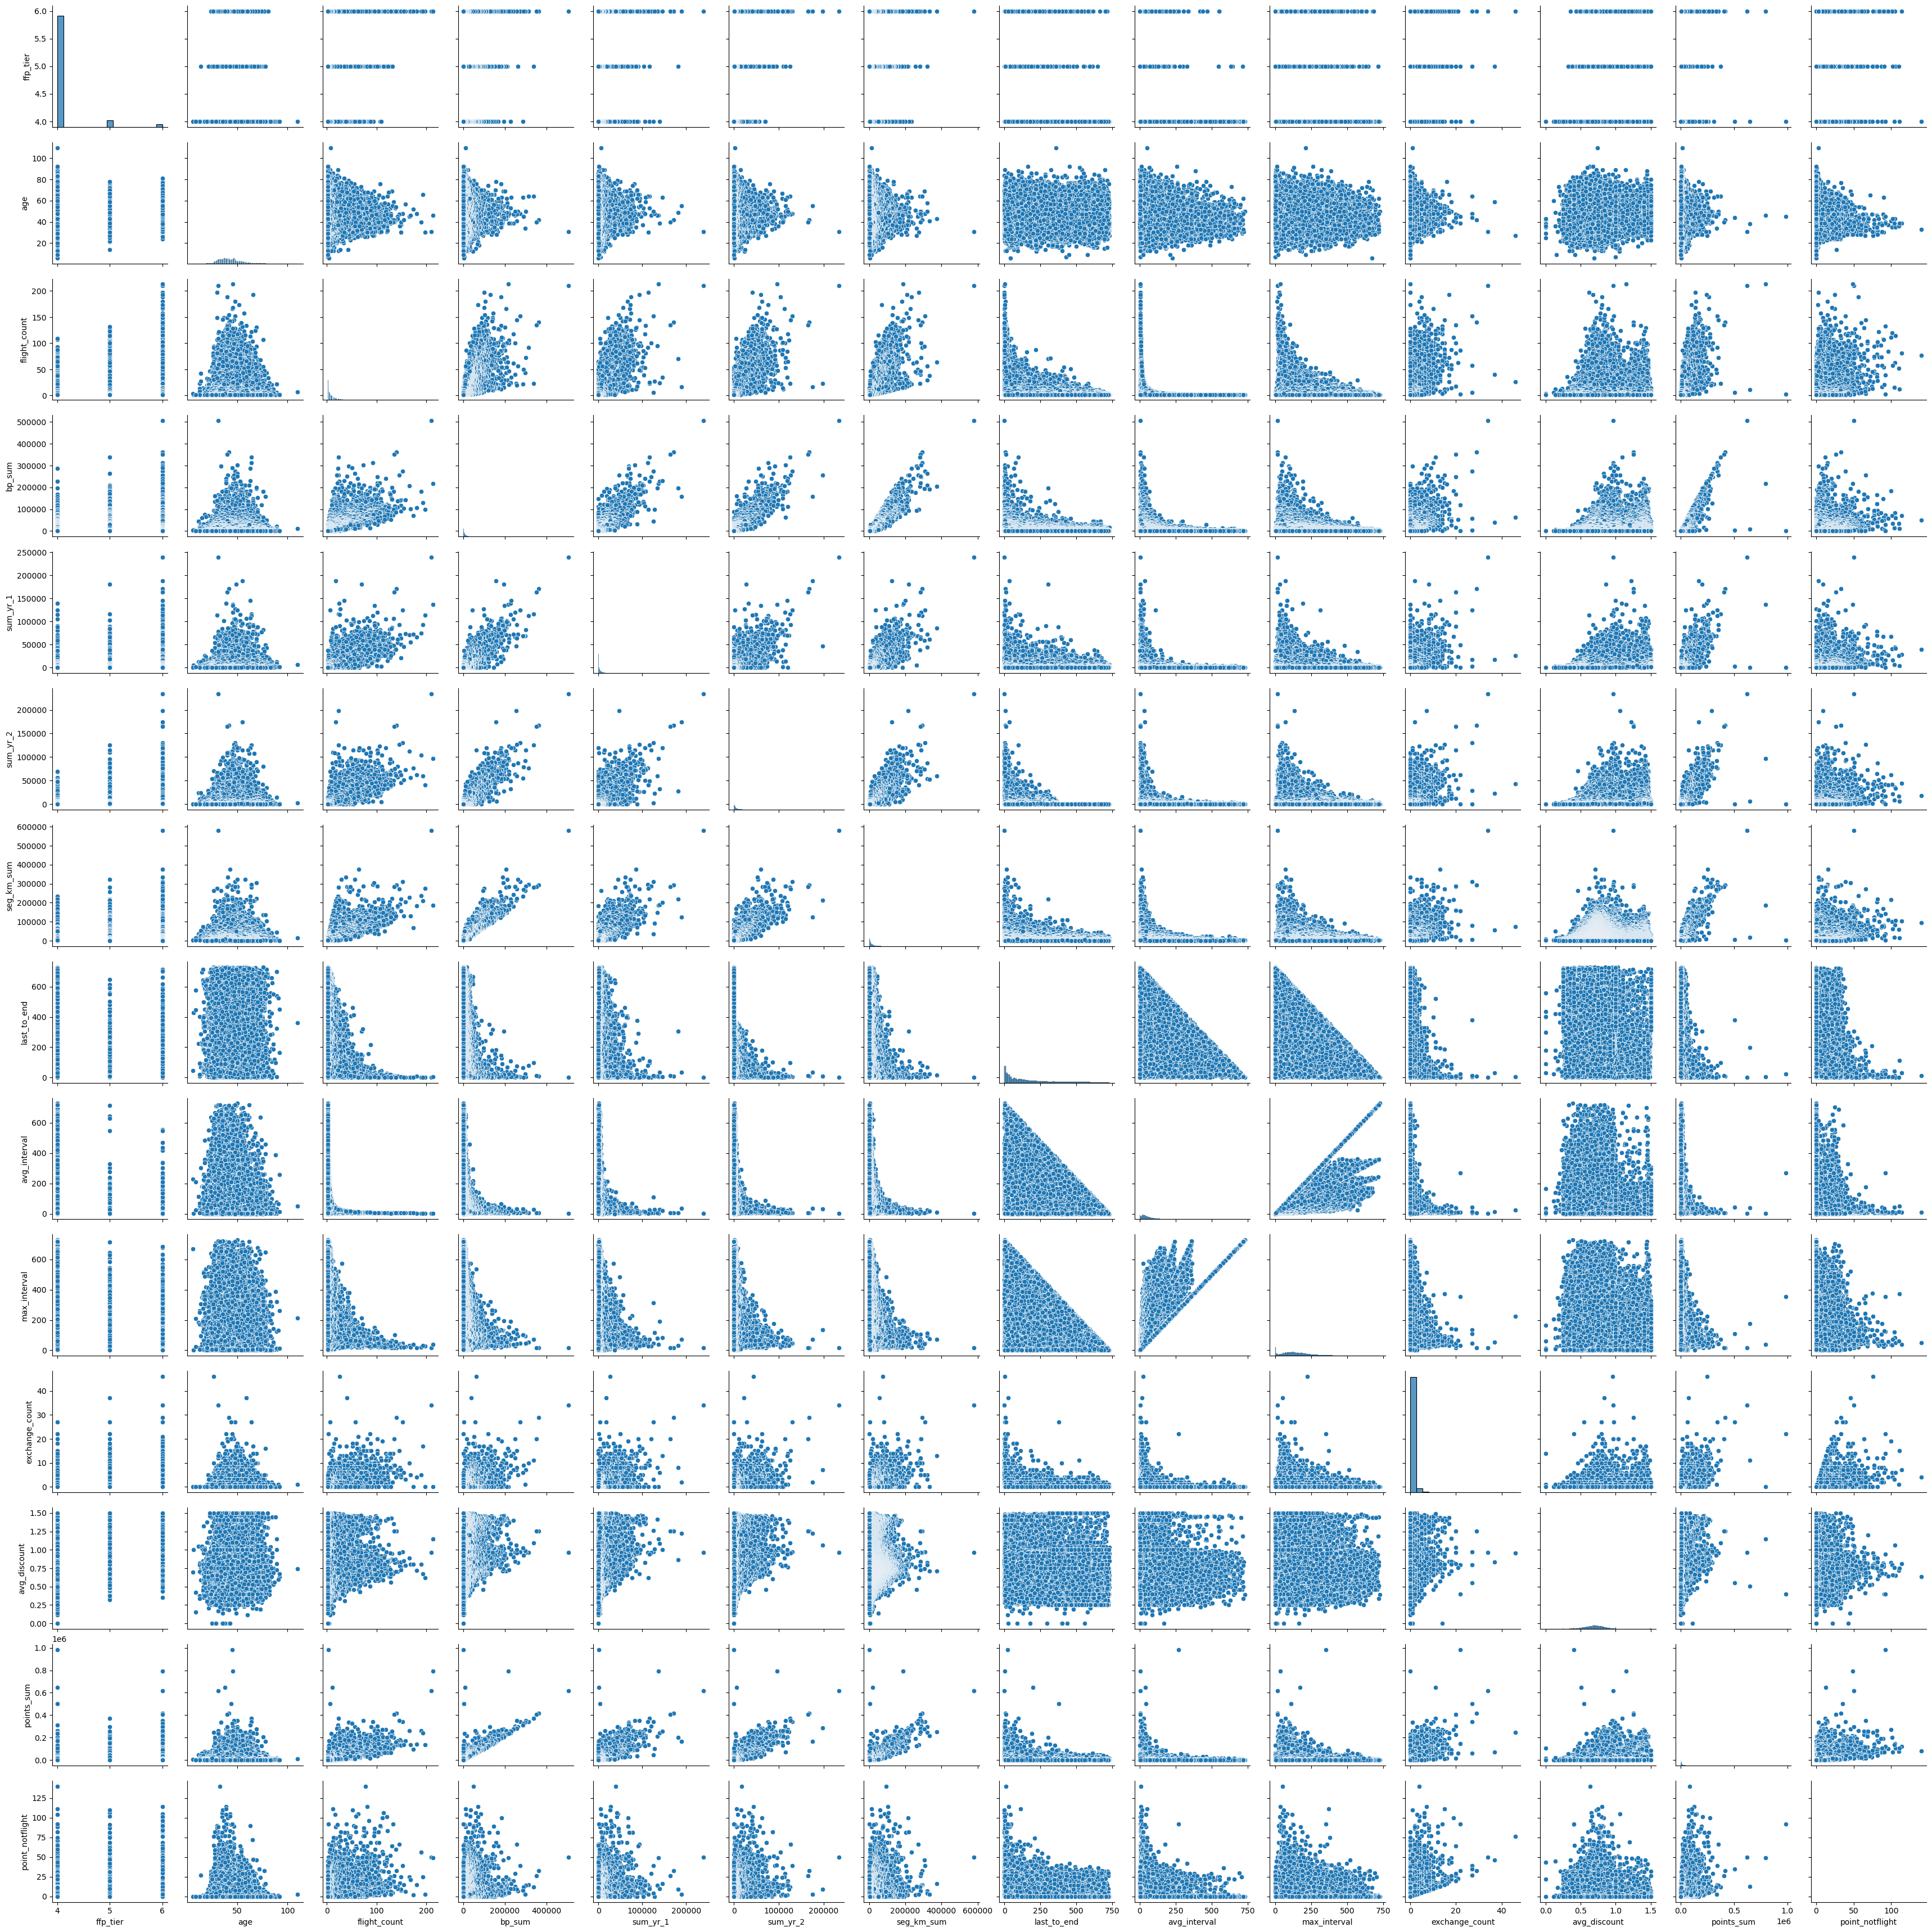

In [17]:
sns.pairplot(df)
plt.show()

In [18]:
# columns
categoricals = ['gender', 'work_city', 'work_province', 'work_country']
numericals = ['ffp_tier', 'age', 'flight_count', 'bp_sum', 'sum_yr_1', 'sum_yr_2', 'seg_km_sum', 'last_to_end', 'avg_interval', 'max_interval', 'exchange_count', 'avg_discount', 'points_sum',
              'point_notflight']
timestamp = ['ffp_date', 'first_flight_date', 'load_time', 'last_flight_date']

In [19]:
# categoricals columns describe
df[categoricals].describe()

gender  work_city work_province work_country
count   62984      60718         59739        62961
unique      2       3234          1165          118
top      Male  guangzhou     guangdong           CN
freq    48133       9386         17509        57747

In [20]:
# numericals columns describe (including datetime)
df.describe(include=['number', 'datetime'])

ffp_date              first_flight_date  \
count                          62987                          62987   
mean   2010-03-06 23:38:30.591074560  2010-09-01 17:43:32.024703488   
min              2004-11-01 00:00:00            1905-12-31 00:00:00   
25%              2008-04-12 00:00:00            2008-12-14 12:00:00   
50%              2010-10-08 00:00:00            2011-04-23 00:00:00   
75%              2012-03-29 00:00:00            2012-07-26 00:00:00   
max              2013-03-31 00:00:00            2015-05-30 00:00:00   
std                              NaN                            NaN   

           ffp_tier           age            load_time  flight_count  \
count  62987.000000  62567.000000                62987  62987.000000   
mean       4.102164     42.476385  2014-03-31 00:00:00     11.839570   
min        4.000000      6.000000  2014-03-31 00:00:00      2.000000   
25%        4.000000     35.000000  2014-03-31 00:00:00      3.000000   
50%        4.000000     41.000000  2014-03-31 00:00:00      7.000000   
75%        4.000000     48.000000  2014-03-31 00:00:00     15.000000   
max        6.000000    110.000000  2014-03-31 00:00:00    213.000000   
std        0.373859      9.885989                  NaN     14.049528   

              bp_sum       sum_yr_1       sum_yr_2     seg_km_sum  \
count   62987.000000   62436.000000   62849.000000   62987.000000   
mean    10925.225475    5355.423382    5604.115181   17124.073650   
min         0.000000       0.000000       0.000000     368.000000   
25%      2518.000000    1003.000000     780.000000    4747.000000   
50%      5700.000000    2800.000000    2773.000000    9994.000000   
75%     12831.000000    6574.250000    6846.000000   21271.500000   
max    505308.000000  239560.000000  234188.000000  580717.000000   
std     16339.575767    8109.506470    8703.404781   20960.953906   

                    last_flight_date   last_to_end  avg_interval  \
count                          62987  62987.000000  62987.000000   
mean   2013-10-07 14:50:54.230237696    176.113500     67.750752   
min              2012-04-01 00:00:00      1.000000      0.000000   
25%              2013-07-08 12:00:00     29.000000     23.370370   
50%              2013-12-15 00:00:00    108.000000     44.666667   
75%              2014-03-03 00:00:00    267.500000     82.000000   
max              2014-03-31 00:00:00    731.000000    728.000000   
std                              NaN    183.816213     77.518103   

       max_interval  exchange_count  avg_discount     points_sum  \
count  62987.000000    62987.000000  62987.000000   62987.000000   
mean     166.036420        0.319780      0.721560   12545.947053   
min        0.000000        0.000000      0.000000       0.000000   
25%       79.000000        0.000000      0.612002    2775.000000   
50%      143.000000        0.000000      0.711857    6329.000000   
75%      228.000000        0.000000      0.809480   14303.000000   
max      728.000000       46.000000      1.500000  985572.000000   
std      123.396532        1.136013      0.185427   20507.935139   

       point_notflight  
count     62987.000000  
mean          2.728198  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           1.000000  
max         140.000000  
std           7.364214

Berdasarkan statistik deskriptif, ditemukan bahwa untuk `first_flight_date` terdapat tanggal yang cukup aneh yaitu pada nilai minimalnya. Penerbangan komersial pertama di dunia terjadi di tahun 1914 dan kemungkinan data tersebut merupakan bagian dari data set ini sangat kecil, sehingga diduga terjadi kesalahan pada data tersebut. Jika fitur tersebut digunakan (ataupun derivatifnya seperti tahun dan bulan) maka perlu diperiksa apakah ada data-data lainnya yang berada terlalu jauh dari nilai mean/mediannya (outliers yang diduga merupakan salah ketik)

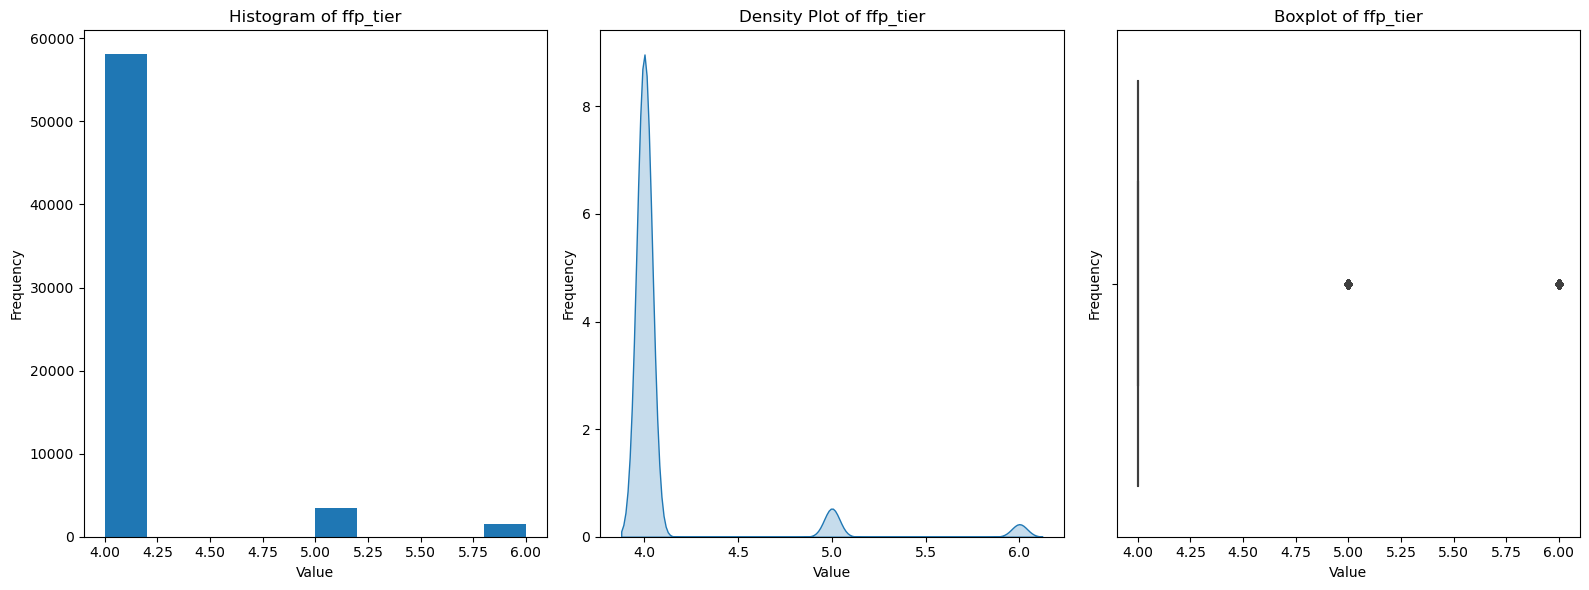

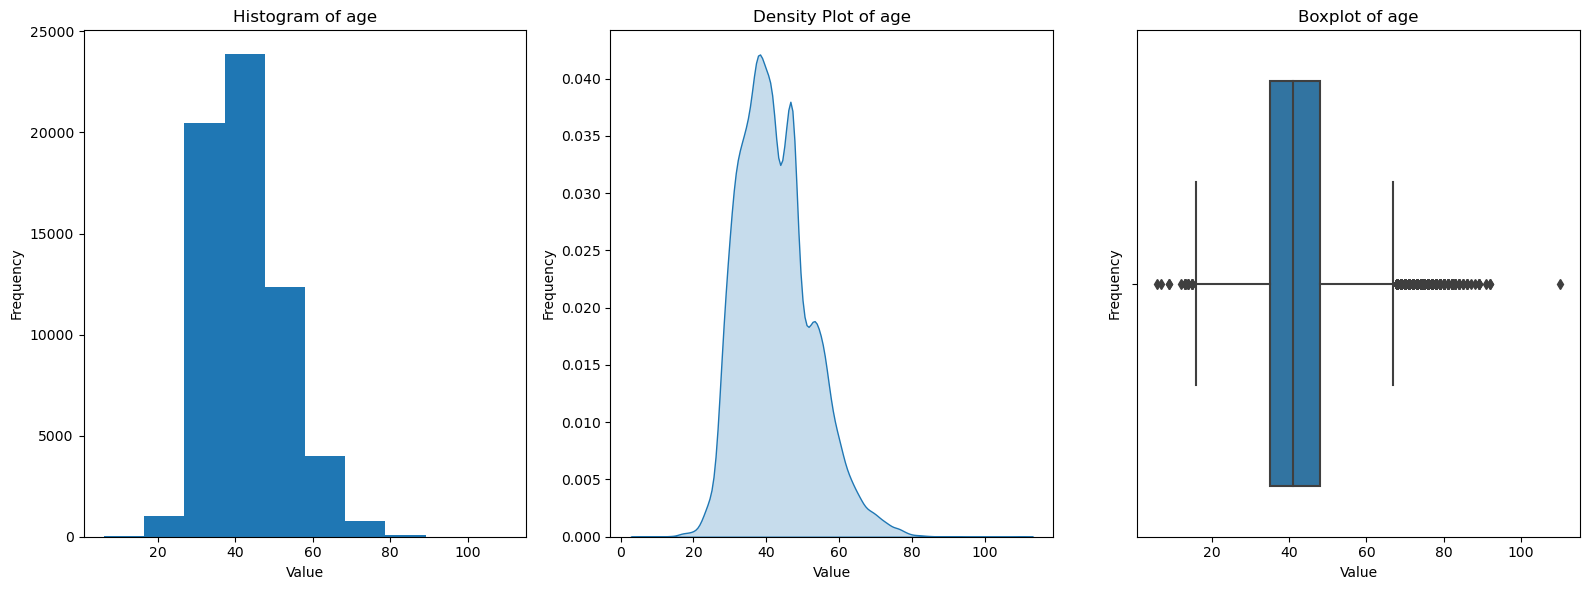

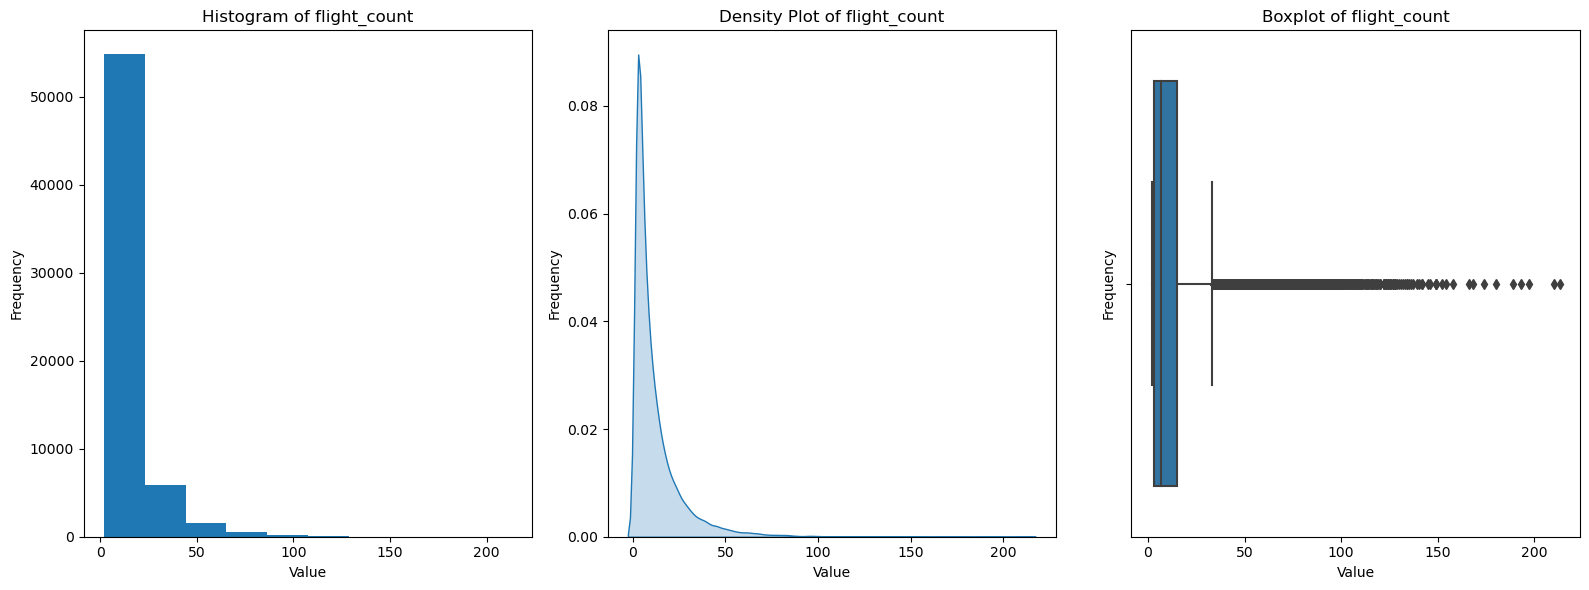

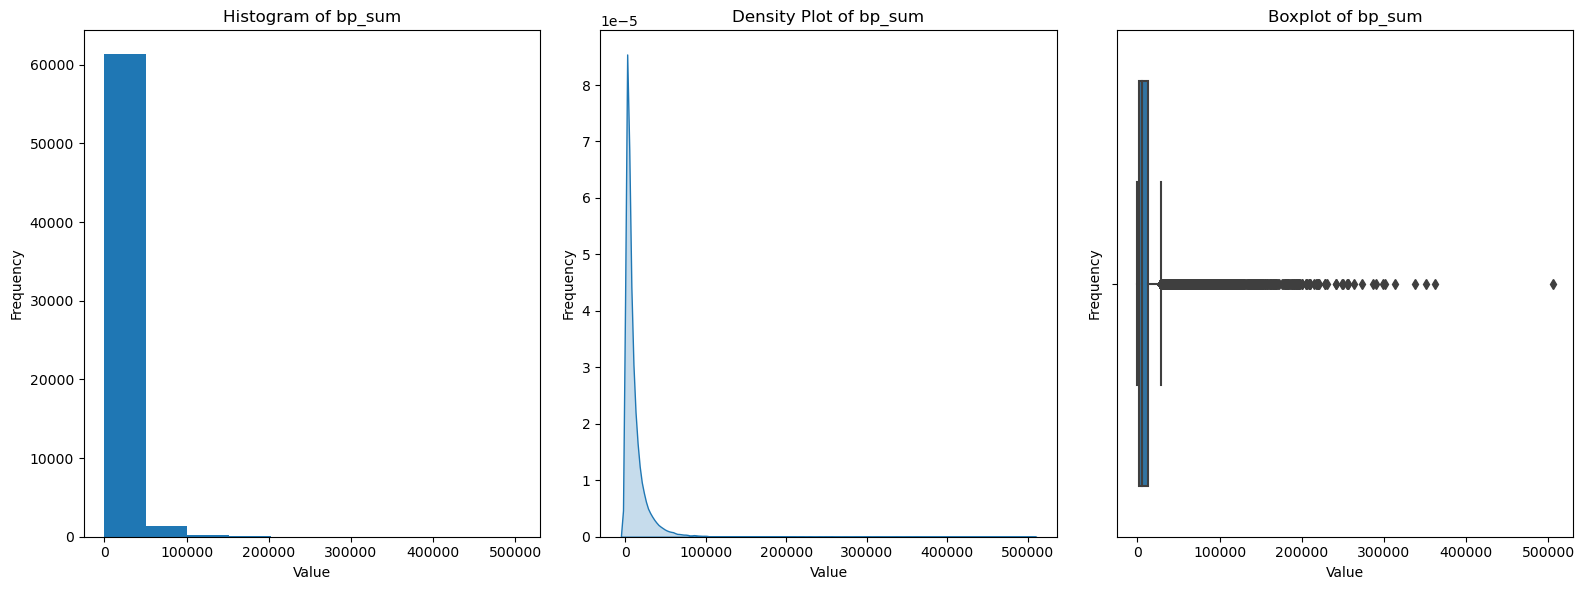

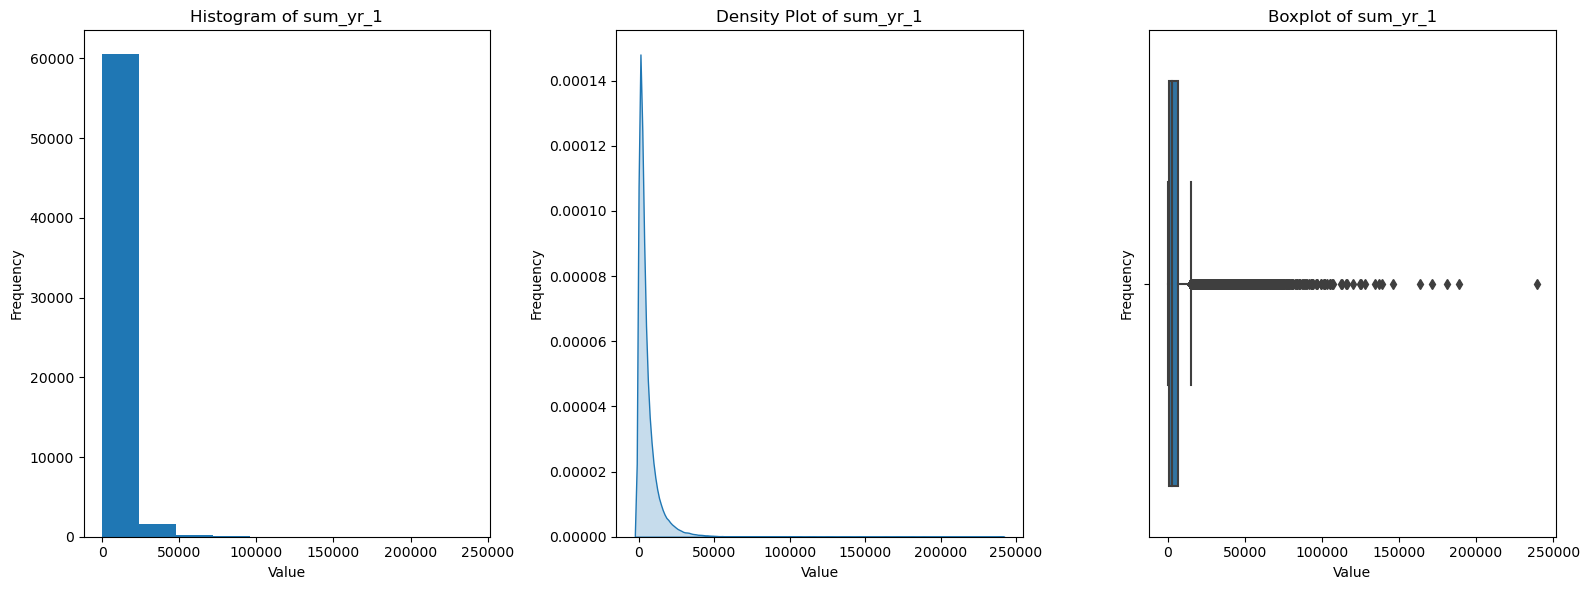

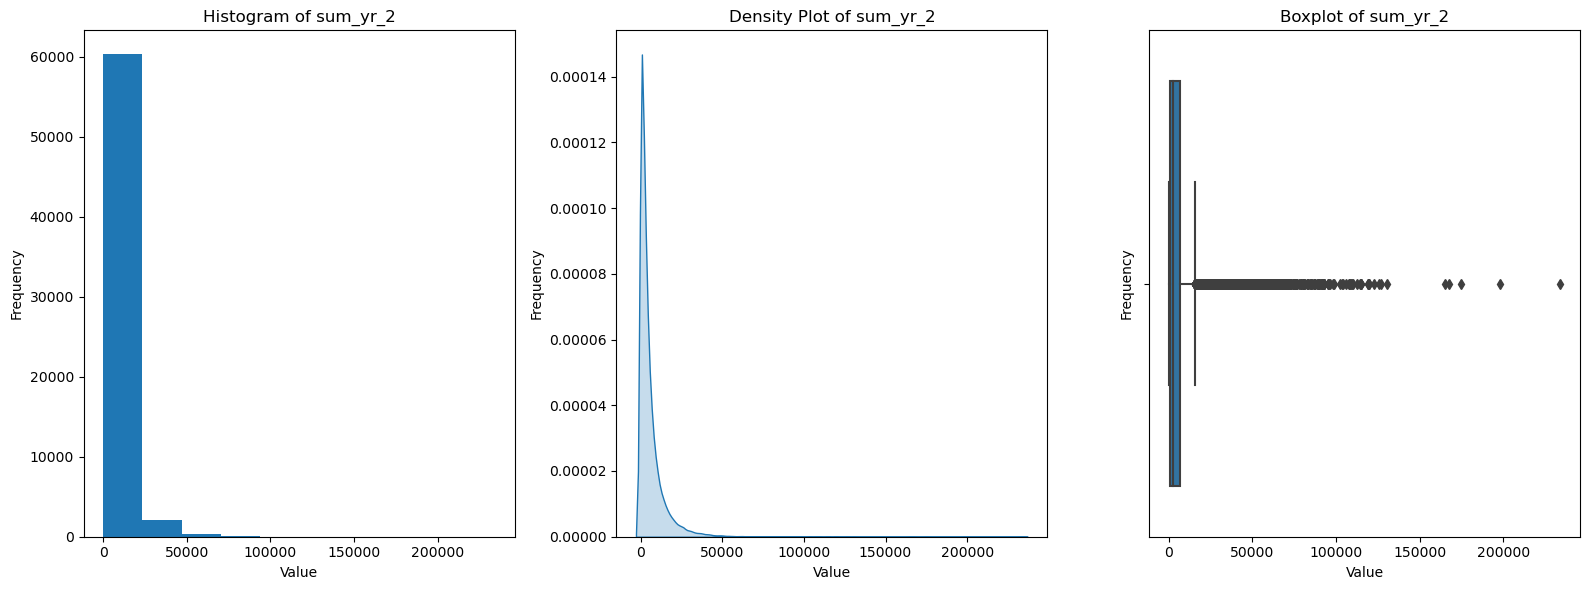

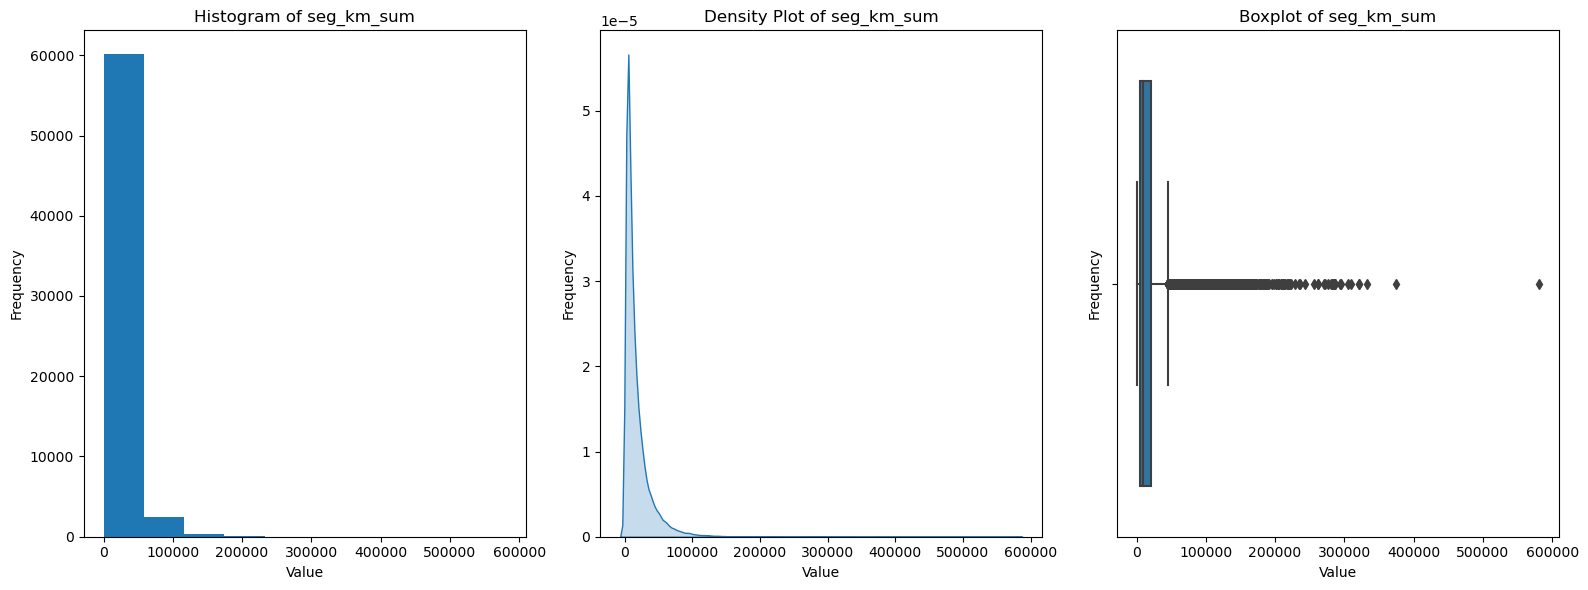

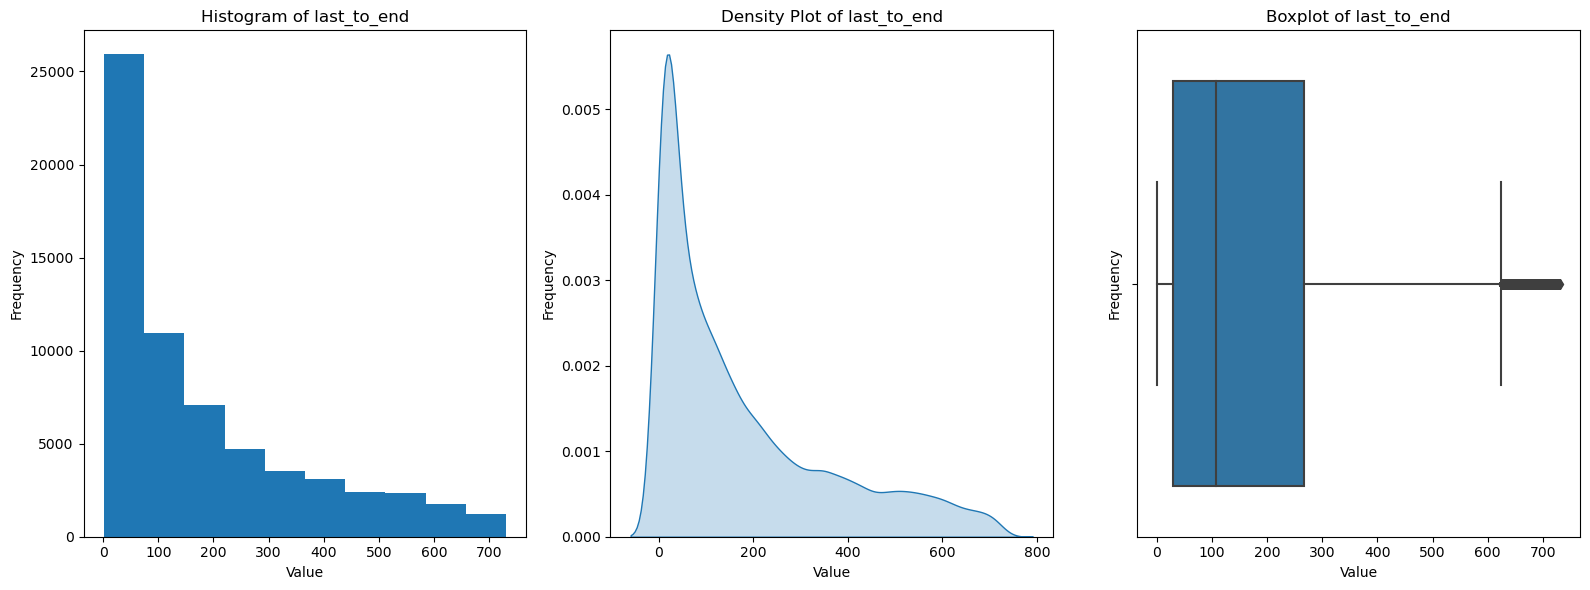

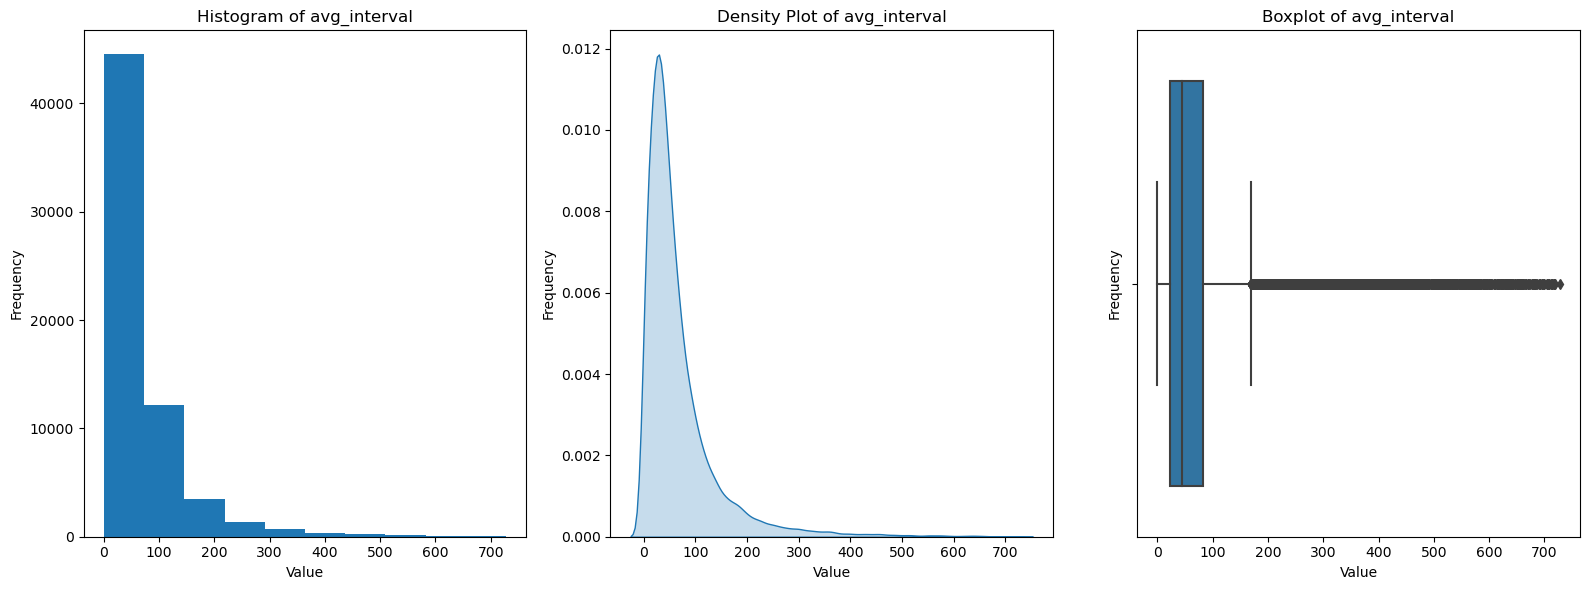

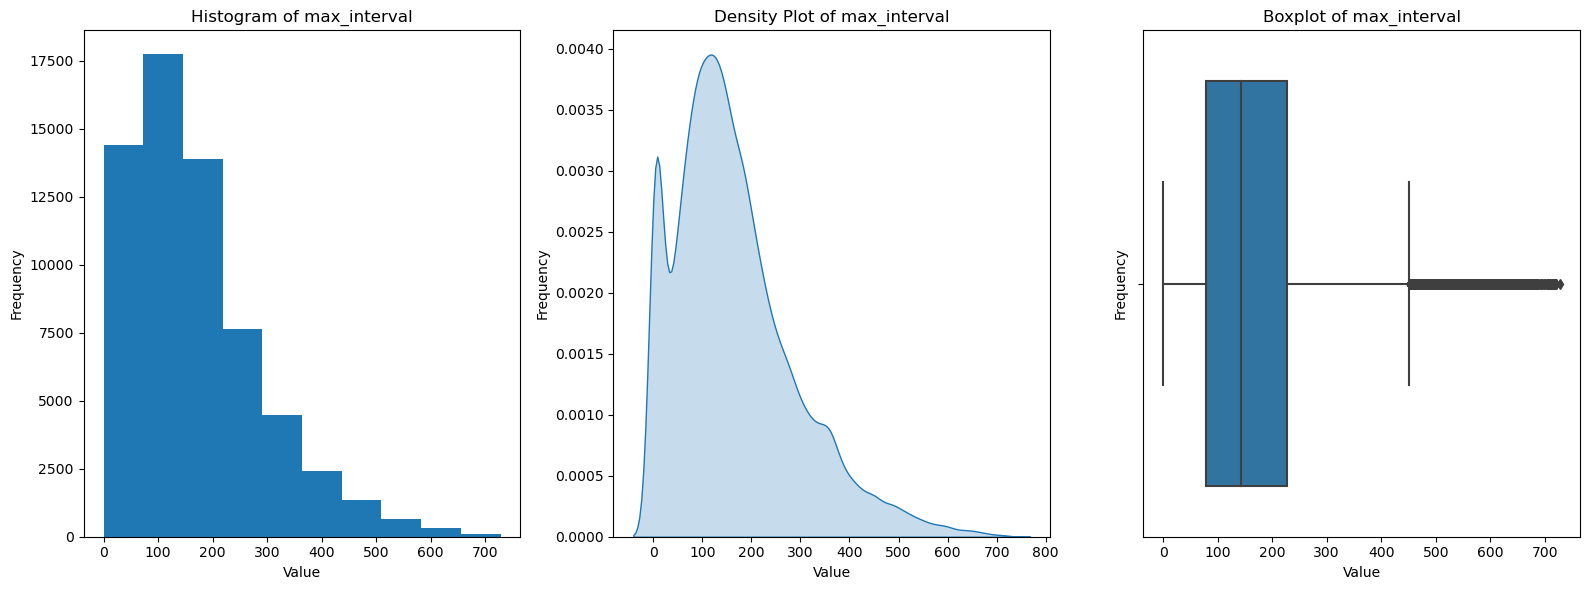

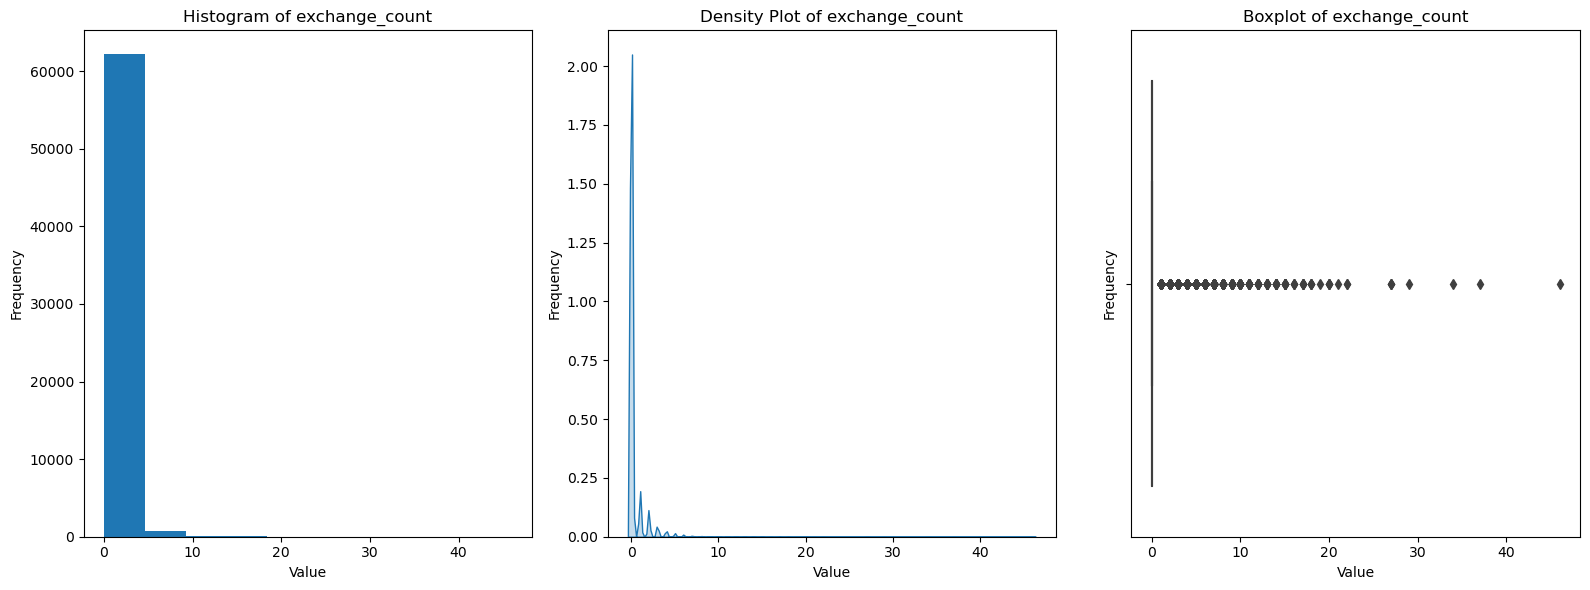

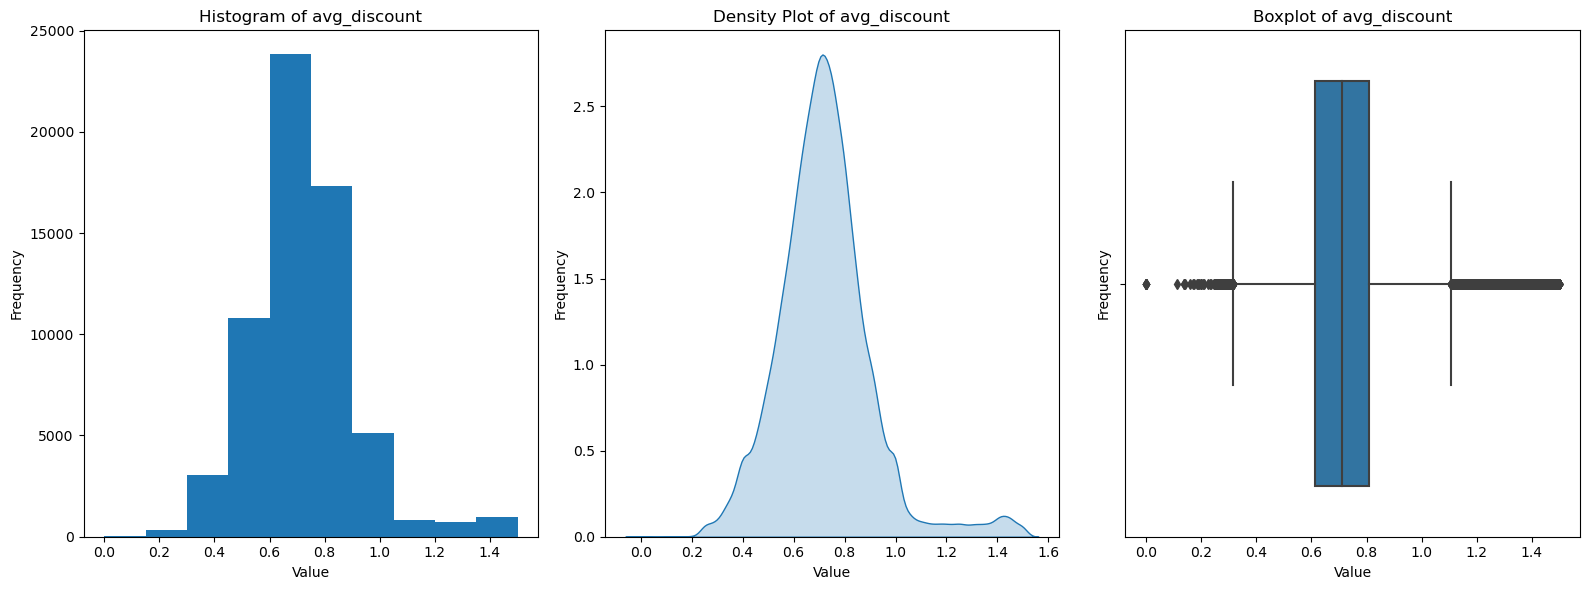

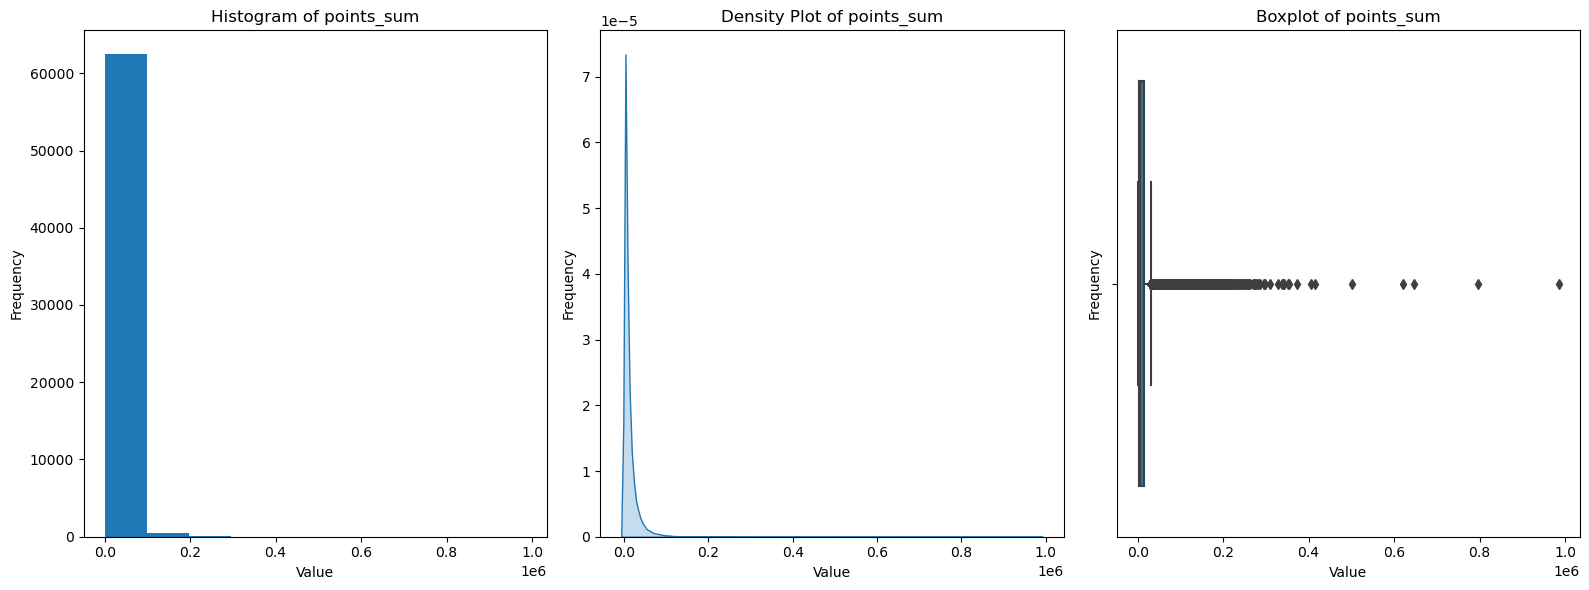

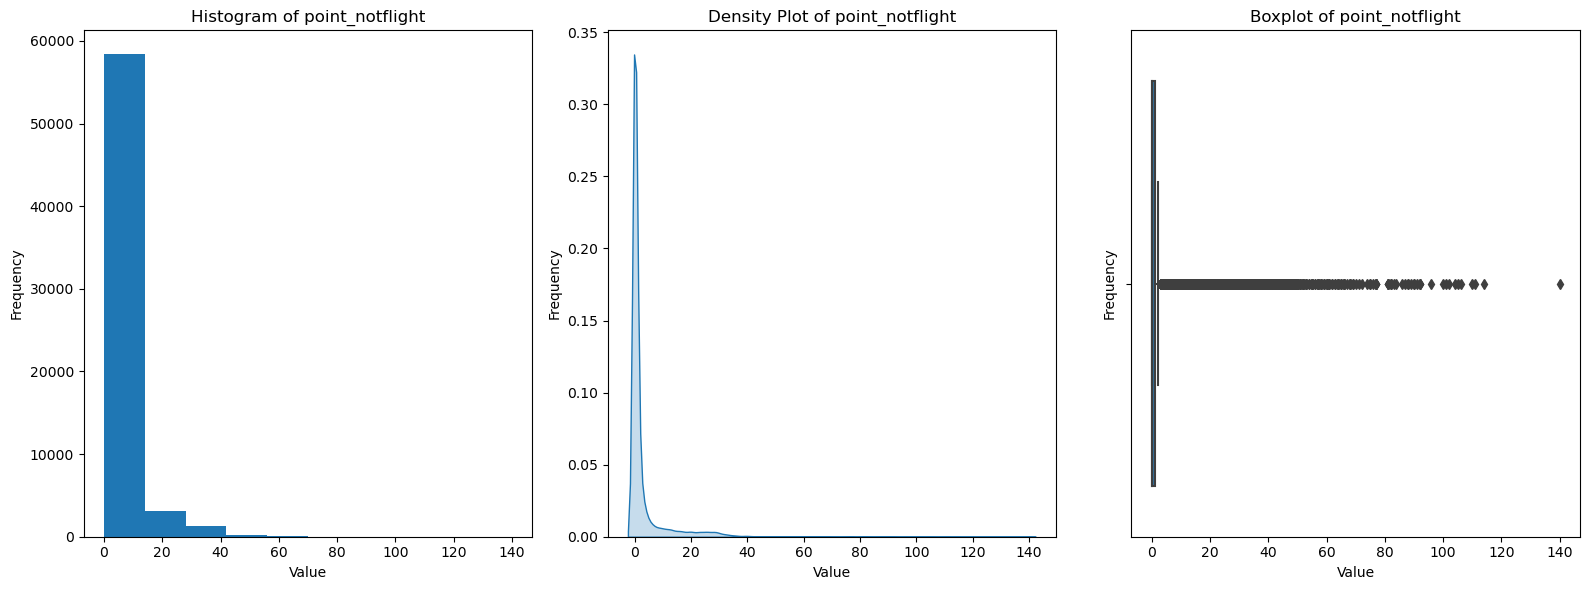

In [21]:
num = df[numericals]

# create figure with 3 subplots
for col in num:
    fig, ax = plt.subplots(1, 3, figsize=(16, 6))
    
    # Histogram
    ax[0].hist(num[col], bins=10)
    ax[0].set_xlabel('Value')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title('Histogram of {}'.format(col))
    
    # Density Plot
    sns.kdeplot(num[col], ax=ax[1], fill=True)
    ax[1].set_xlabel('Value')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title('Density Plot of {}'.format(col))
    
    # Boxplot
    sns.boxplot(x=num[col], ax=ax[2])
    ax[2].set_xlabel('Value')
    ax[2].set_ylabel('Frequency')
    ax[2].set_title('Boxplot of {}'.format(col))
    
    # Show Plots
    plt.tight_layout()
    plt.show

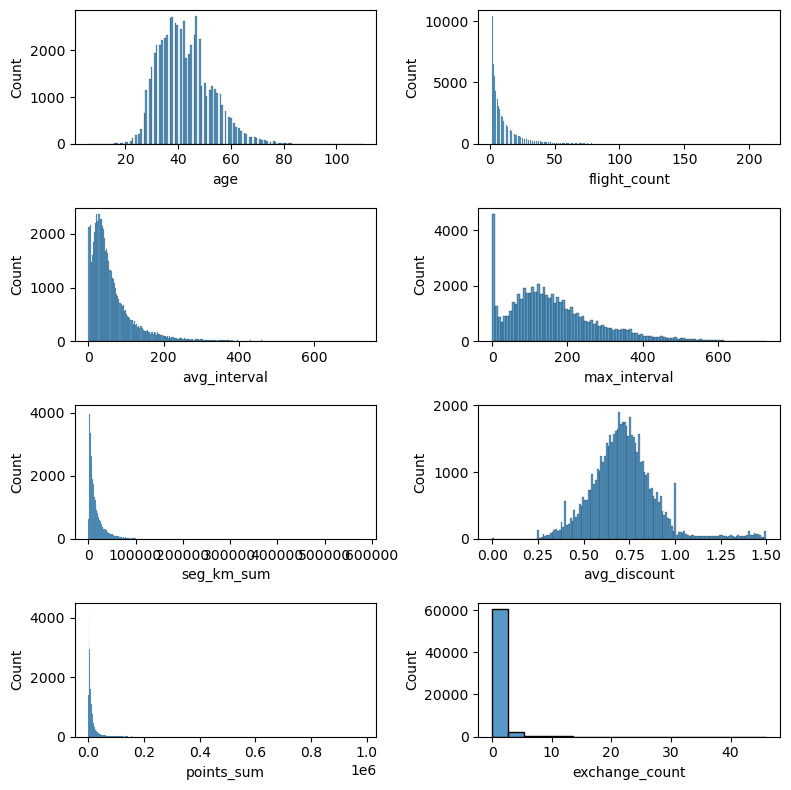

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(8,8))
sns.histplot(data=df, x='age', ax=axs[0][0])
sns.histplot(data=df, x='flight_count', ax=axs[0][1])
sns.histplot(data=df, x='avg_interval', ax=axs[1][0])
sns.histplot(data=df, x='max_interval', ax=axs[1][1])
sns.histplot(data=df, x='seg_km_sum', ax=axs[2][0])
sns.histplot(data=df, x='avg_discount', ax=axs[2][1])
sns.histplot(data=df, x='points_sum', ax=axs[3][0])
sns.histplot(data=df, x='exchange_count', ax=axs[3][1])

fig.tight_layout()
plt.show()

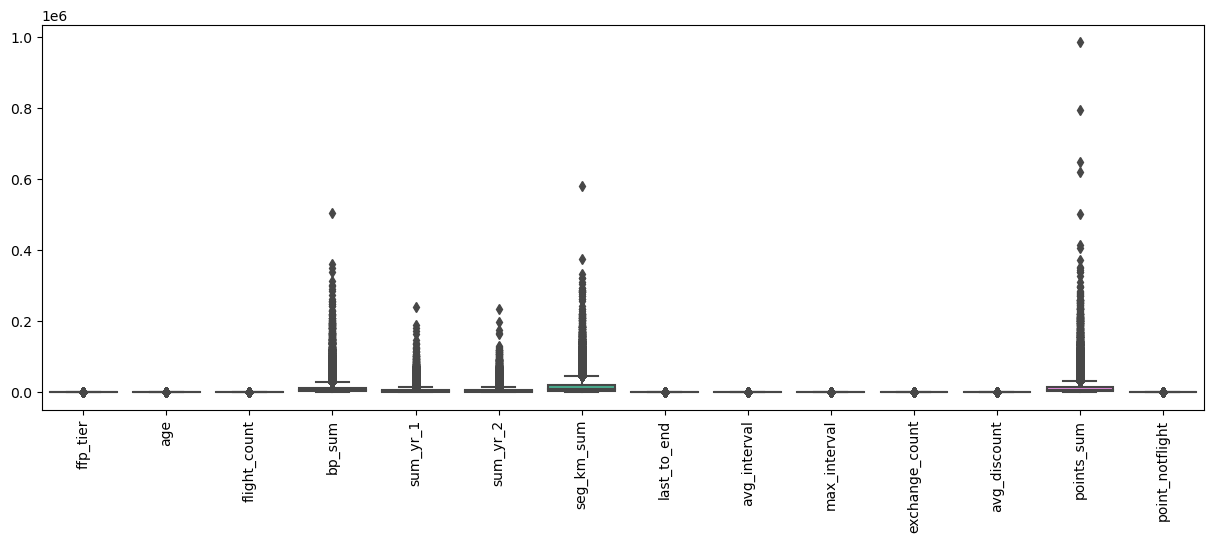

In [23]:
# Check for outliers using box plots
plt.figure(figsize=(15,5))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

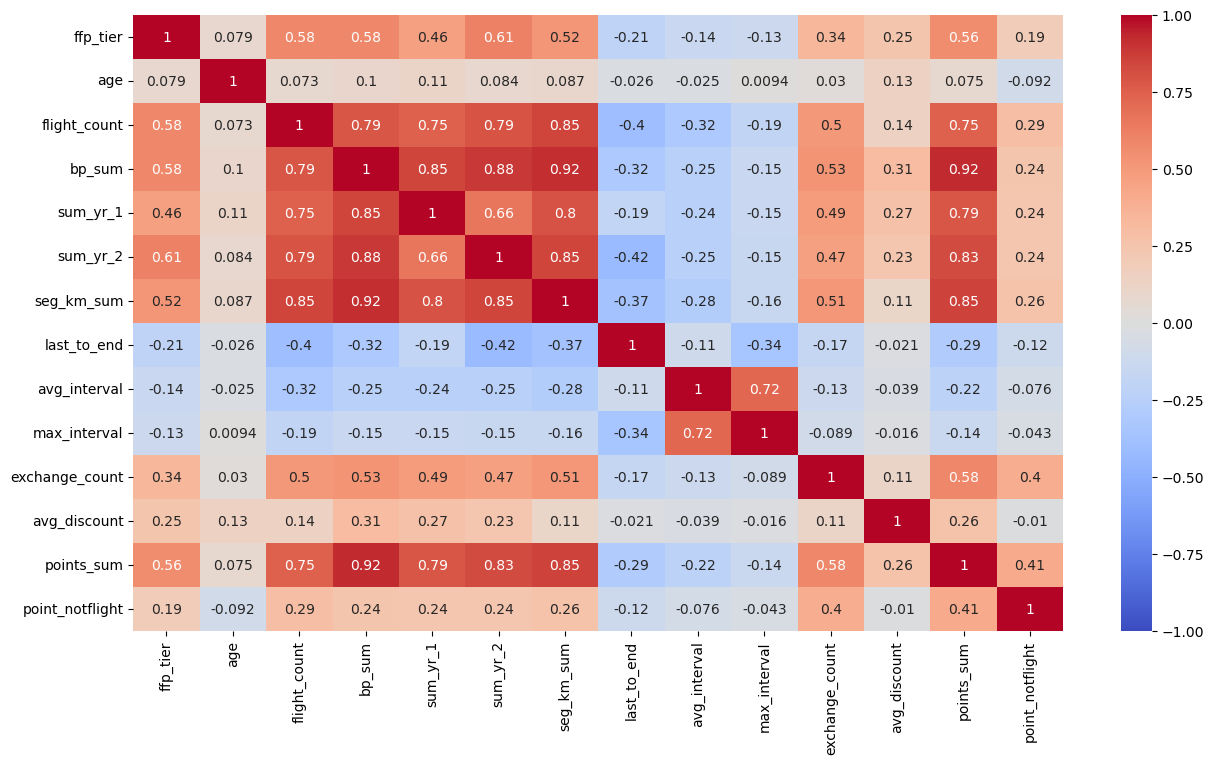

In [24]:
# Check the correlation between variables using heatmap
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [25]:
# convert the dates to year and month
df['ffp_date_year'] = df['ffp_date'].dt.year
df['first_flight_date_year'] = df['first_flight_date'].dt.year
df['last_flight_date_year'] = df['last_flight_date'].dt.year

# print the dataframe
df.head()

ffp_date first_flight_date gender  ffp_tier    work_city work_province  \
0 2006-11-02        2008-12-24   Male         6            .       beijing   
1 2007-02-19        2007-08-03   Male         6          NaN       beijing   
2 2007-02-01        2007-08-30   Male         6            .       beijing   
3 2008-08-22        2008-08-23   Male         5  Los Angeles            CA   
4 2009-04-10        2009-04-15   Male         6      guiyang       guizhou   

  work_country   age  load_time  flight_count  ...  last_to_end  avg_interval  \
0           CN  31.0 2014-03-31           210  ...            1      3.483254   
1           CN  42.0 2014-03-31           140  ...            7      5.194245   
2           CN  40.0 2014-03-31           135  ...           11      5.298507   
3           US  64.0 2014-03-31            23  ...           97     27.863636   
4           CN  48.0 2014-03-31           152  ...            5      4.788079   

   max_interval  exchange_count avg_discount  points_sum  point_notflight  \
0            18              34     0.961639      619760               50   
1            17              29     1.252314      415768               33   
2            18              20     1.254676      406361               26   
3            73              11     1.090870      372204               12   
4            47              27     0.970658      338813               39   

   ffp_date_year  first_flight_date_year  last_flight_date_year  
0           2006                    2008                   2014  
1           2007                    2007                   2014  
2           2007                    2007                   2014  
3           2008                    2008                   2013  
4           2009                    2009                   2014  

[5 rows x 25 columns]

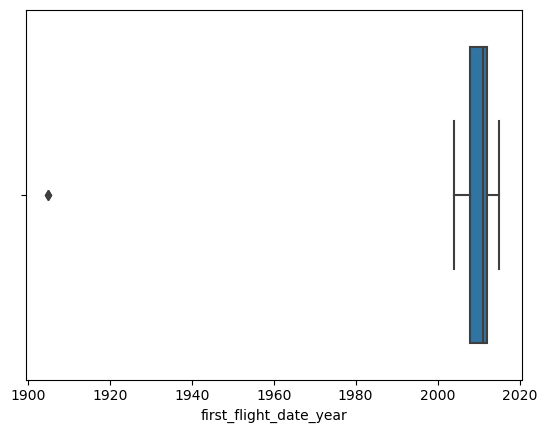

In [26]:
# check distribution of first flight date year
sns.boxplot(x=df["first_flight_date_year"])
plt.show()

In [27]:
# check strange values on first flight date year
df[df["first_flight_date_year"] < 2000]

ffp_date first_flight_date  gender  ffp_tier     work_city  \
4455  2011-02-27        1905-12-31    Male         4        dalian   
30099 2004-11-10        1905-12-31  Female         4  guangzhoushi   

        work_province work_country   age  load_time  flight_count  ...  \
4455         liaoning           CN  35.0 2014-03-31            40  ...   
30099  guangdongsheng           CN  37.0 2014-03-31             8  ...   

       last_to_end  avg_interval  max_interval  exchange_count avg_discount  \
4455            18     18.051282            92               1     0.688062   
30099          134     75.000000           178               1     0.775909   

       points_sum  point_notflight  ffp_date_year  first_flight_date_year  \
4455        33588               27           2011                    1905   
30099       26192               38           2004                    1905   

       last_flight_date_year  
4455                    2014  
30099                   2013  

[2 rows x 25 columns]

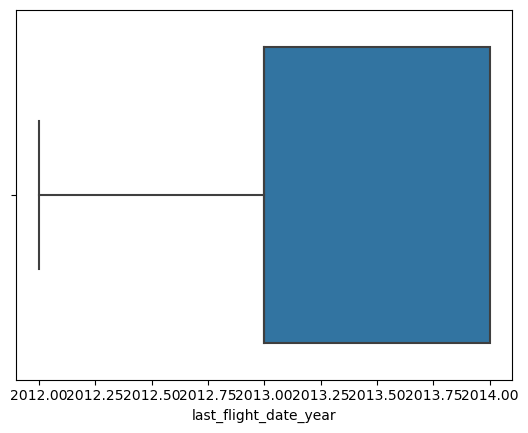

In [28]:
# check distribution of last flight date year
sns.boxplot(x=df["last_flight_date_year"])
plt.show()

Terdapat dua baris dimana tahun penerbangan pertamanya 1905, dimana nilai tersebut bukan nilai yang dianggap masuk akal. Kemungkinan yang terjadi adalah data tidak ada sehingga diisi dengan nilai yang sangat rendah. Jika fitur ini digunakan untuk clustering, maka kedua baris ini harus diubah tahun terbang pertamanya, atau dihapus karena dianggap outlier.

Pada tahun penerbangan terakhir, tidak terdapat data outlier sehingga data aman untuk langsung digunakan tanpa penghapusan outier.


In [29]:
# memeriksa outlier dari tiap kolom numerik menggunakan z-score test
from scipy import stats

numericals = ['ffp_tier', 'age', 'flight_count', 'bp_sum', 'sum_yr_1', 'sum_yr_2', 'seg_km_sum', 'last_to_end', 'avg_interval', 'max_interval', 'exchange_count', 'avg_discount', 'points_sum',
              'point_notflight', 'ffp_date_year', 'first_flight_date_year', 'last_flight_date_year']

zscore = pd.DataFrame()
outlier = pd.DataFrame()
filtered_zscore = np.array([True] * len(df))

for col in numericals:
    zscore = abs(stats.zscore(df[col])) # hitung absolute z-scorenya
    outlier[col] = df[col][zscore>3]
    filtered_zscore = (zscore < 3) & filtered_zscore 

outlier.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1513 entries, 0 to 62255
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ffp_tier                1513 non-null   int64  
 1   age                     0 non-null      float64
 2   flight_count            555 non-null    float64
 3   bp_sum                  551 non-null    float64
 4   sum_yr_1                0 non-null      float64
 5   sum_yr_2                0 non-null      float64
 6   seg_km_sum              476 non-null    float64
 7   last_to_end             0 non-null      float64
 8   avg_interval            8 non-null      float64
 9   max_interval            8 non-null      float64
 10  exchange_count          336 non-null    float64
 11  avg_discount            314 non-null    float64
 12  points_sum              541 non-null    float64
 13  point_notflight         164 non-null    float64
 14  ffp_date_year           0 non-null      floa

In [30]:
#drop outlier
print(f'jumlah baris data SEBELUM filter outlier: {len(df)}')

# get index of outliers
outlier_id = outlier.index
df_outlier_removed = df.drop(outlier_id)

print(f'jumlah baris data SETELAH filter outlier: {len(df_outlier_removed)}')

jumlah baris data SEBELUM filter outlier: 62987
jumlah baris data SETELAH filter outlier: 61474


# Feature Engineering
Petunjuk:
* Dari sekian banyak kolom yang ada, tentukan 3-6 fitur untuk digunakan sebagai fitur clustering. Tulis alasan teman-teman memilih fitur tersebut.

* Lakukan preprocessing dan feature engineering (apabila fitur yang teman-teman
pilih merupakan fitur baru yang dihasilkan dari fitur-fitur yang sudah ada).

## Feature Scaling

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [32]:
# New DataFrame containing relevant column (column not fixed yet)
selected_features = ['avg_discount', 'points_sum', 'seg_km_sum', 'flight_count']
clustering_df = df_outlier_removed[selected_features].copy()

In [33]:
# Data statistics before scaled
clustering_df.describe()

avg_discount     points_sum     seg_km_sum  flight_count
count  61474.000000   61474.000000   61474.000000  61474.000000
mean       0.715697   11167.528272   15965.063230     11.004750
std        0.178900   15704.788286   17906.129596     11.903707
min        0.000000       0.000000     368.000000      2.000000
25%        0.609097    2726.000000    4674.000000      3.000000
50%        0.709090    6142.000000    9747.000000      7.000000
75%        0.804898   13593.000000   20382.750000     14.000000
max        1.500000  985572.000000  321529.000000    132.000000

In [34]:
# Add Imputer to handle missing values
imputer = SimpleImputer(strategy='median')
clustering_df[['points_sum', 'seg_km_sum']] = imputer.fit_transform(clustering_df[['points_sum', 'seg_km_sum']])

In [35]:
# Scale using StandardScaler
scaler = StandardScaler()
clustering_df_scaled = scaler.fit_transform(clustering_df)

In [36]:
# Convert scaled data to DataFrame
clustering_df_scaled = pd.DataFrame(clustering_df_scaled, columns=selected_features)

In [37]:
# Show scaled data statistics
clustering_df_scaled.describe()

avg_discount    points_sum    seg_km_sum  flight_count
count  6.147400e+04  6.147400e+04  6.147400e+04  6.147400e+04
mean   4.512410e-16  6.657654e-17  5.917915e-17  7.397393e-17
std    1.000008e+00  1.000008e+00  1.000008e+00  1.000008e+00
min   -4.000579e+00 -7.110964e-01 -8.710531e-01 -7.564722e-01
25%   -5.958669e-01 -5.375174e-01 -6.305749e-01 -6.724640e-01
50%   -3.693001e-02 -3.200023e-01 -3.472617e-01 -3.364315e-01
75%    4.986153e-01  1.544428e-01  2.467157e-01  2.516253e-01
max    4.384071e+00  6.204556e+01  1.706491e+01  1.016458e+01

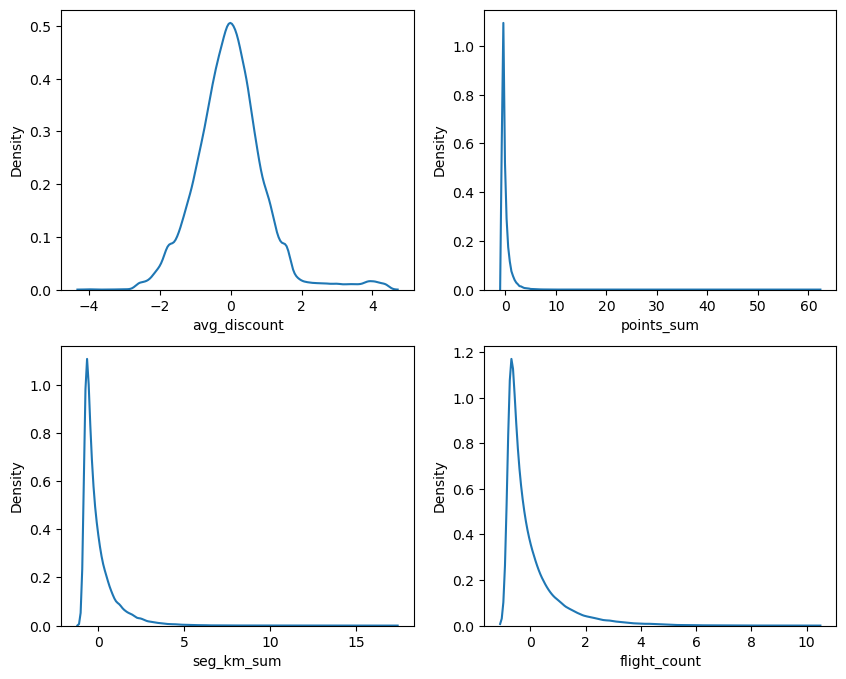

In [38]:
# Create a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Create a histogram plot of each column in a separate subplot
sns.kdeplot(data=clustering_df_scaled, x="avg_discount", ax=axs[0, 0])
sns.kdeplot(data=clustering_df_scaled, x="points_sum", ax=axs[0, 1])
sns.kdeplot(data=clustering_df_scaled, x="seg_km_sum", ax=axs[1, 0])
sns.kdeplot(data=clustering_df_scaled, x="flight_count", ax=axs[1, 1])

plt.show()

## Feature Transformation

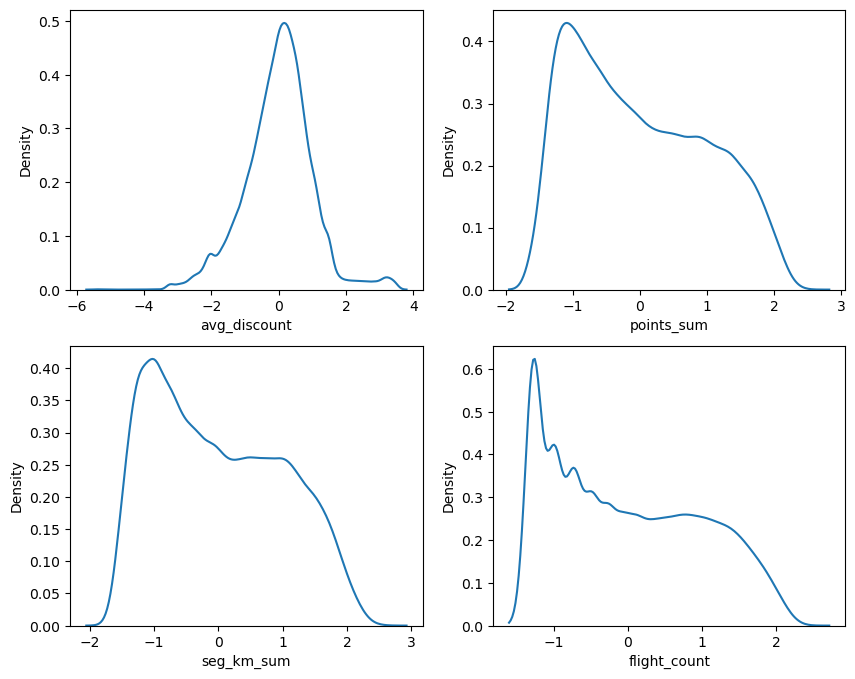

In [39]:
from sklearn.preprocessing import PowerTransformer

# Perform power transformation on skewed data
pt = PowerTransformer(method='yeo-johnson')
clustering_df_transformed = pt.fit_transform(clustering_df_scaled)

# Convert transformed data back to DataFrame
clustering_df_transformed = pd.DataFrame(clustering_df_transformed, columns=clustering_df_scaled.columns)


# Create a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Create a histogram plot of each column in a separate subplot
sns.kdeplot(data=clustering_df_transformed, x="avg_discount", ax=axs[0, 0])
sns.kdeplot(data=clustering_df_transformed, x="points_sum", ax=axs[0, 1])
sns.kdeplot(data=clustering_df_transformed, x="seg_km_sum", ax=axs[1, 0])
sns.kdeplot(data=clustering_df_transformed, x="flight_count", ax=axs[1, 1])

plt.show()

In [40]:
clustering_df_transformed.describe()

avg_discount    points_sum    seg_km_sum  flight_count
count  6.147400e+04  6.147400e+04  61474.000000  6.147400e+04
mean   2.958957e-17  5.917915e-17      0.000000 -5.917915e-17
std    1.000008e+00  1.000008e+00      1.000008  1.000008e+00
min   -5.385258e+00 -1.624153e+00     -1.722523 -1.270493e+00
25%   -5.630041e-01 -8.782100e-01     -0.885350 -9.889856e-01
50%    5.535569e-02 -1.432963e-01     -0.119453 -7.200432e-02
75%    5.757783e-01  8.224299e-01      0.828952  8.432798e-01
max    3.466596e+00  2.494882e+00      2.592650  2.384888e+00

# Clustering
Petunjuk:
* Temukan jumlah cluster yang optimal dengan menggunakan elbow method

* Lakukan clustering menggunakan K-means

* Evaluasi cluster yang dihasilkan dengan menggunakan visualisasi, gunakan PCA
apabila diperlukan

## Elbow Method

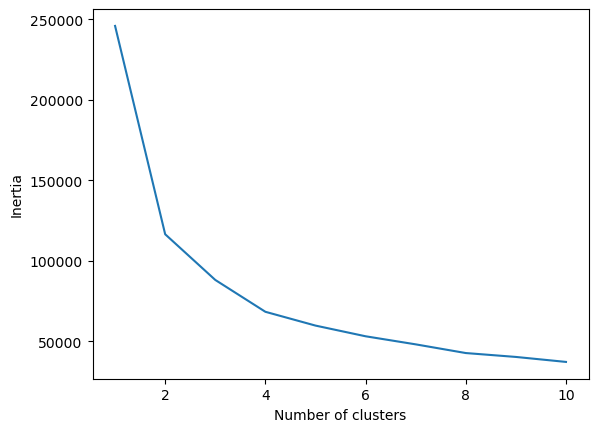

In [41]:
from sklearn.cluster import KMeans

# create an empty list to store the inertia values
inertia = []

# create a range of k values to test
k_range = range(1, 11)

# fit KMeans for each k value and append the inertia to the list
for k in k_range:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(clustering_df_transformed)
    inertia.append(model.inertia_)

# plot the inertia values against k values
plt.plot(k_range, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## K-Means Clustering

In [42]:
# instantiate the KMeans model with the selected number of clusters
model = KMeans(n_clusters=4, n_init='auto') #optimal numbers tidak terlihat jelas yang mana

# fit the model to the scaled data
model.fit(clustering_df_transformed)

# create a new column in the dataframe for the cluster labels
clustering_df_transformed['cluster'] = model.labels_

In [43]:
clustering_df_transformed

avg_discount  points_sum  seg_km_sum  flight_count  cluster
0          1.887937    2.426763    2.553731      1.359164        0
1          0.695280    2.400213    2.592615      2.003676        0
2          0.546091    2.375230    2.592650      1.558090        0
3          1.611718    2.406278    2.496118      1.318148        0
4          0.484725    2.369083    2.554269      1.858802        0
...             ...         ...         ...           ...      ...
61469     -5.385258    0.708036   -1.560341     -1.270493        1
61470     -5.385258    2.198097   -0.355345     -0.729031        1
61471     -5.385258   -1.624153   -1.267306     -1.270493        1
61472     -5.385258   -1.624153   -1.016536     -1.270493        1
61473     -5.385258   -1.624153   -0.964869     -1.270493        1

[61474 rows x 5 columns]

## PCA

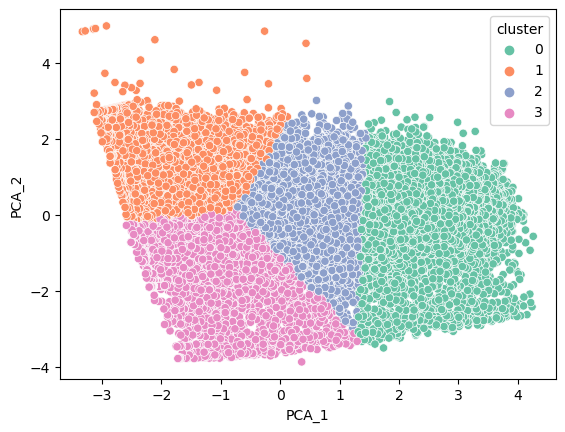

In [44]:
from sklearn.decomposition import PCA

# instantiate PCA model with 2 components
pca = PCA(n_components=2)

# fit and transform the scaled data
pca_transformed = pca.fit_transform(clustering_df_transformed.drop('cluster', axis=1))

# create a new dataframe with the PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_transformed, columns=['PCA_1', 'PCA_2'])
pca_df['cluster'] = clustering_df_transformed['cluster']

# plot the clusters using seaborn
sns.scatterplot(data=pca_df, x='PCA_1', y='PCA_2', hue='cluster', palette='Set2')
plt.show()

# Interpretasi
Petunjuk:
* Tempelkan kembali label yang dihasilkan ke dataframe asal, dan keluarkan statistik fitur dari setiap cluster

* Deskripsikan secara kontekstual customer seperti apa yang ada di masing-masing
cluster

* Berdasarkan cluster tersebut, berikan 1-2 rekomendasi

In [45]:
df2 = df.merge(clustering_df_transformed['cluster'],left_index=True, right_index=True)
df2

ffp_date first_flight_date  gender  ffp_tier    work_city  \
0     2006-11-02        2008-12-24    Male         6            .   
1     2007-02-19        2007-08-03    Male         6          NaN   
2     2007-02-01        2007-08-30    Male         6            .   
3     2008-08-22        2008-08-23    Male         5  Los Angeles   
4     2009-04-10        2009-04-15    Male         6      guiyang   
...          ...               ...     ...       ...          ...   
61469 2010-09-24        2010-09-24    Male         4     ichikawa   
61470 2006-04-30        2007-12-02    Male         4  wulumuqishi   
61471 2012-12-17        2012-12-17  Female         4       dalian   
61472 2011-05-24        2011-05-24    Male         4     shenzhen   
61473 2012-07-23        2012-08-05    Male         4     nanchang   

      work_province work_country   age  load_time  flight_count  ...  \
0           beijing           CN  31.0 2014-03-31           210  ...   
1           beijing           CN  42.0 2014-03-31           140  ...   
2           beijing           CN  40.0 2014-03-31           135  ...   
3                CA           US  64.0 2014-03-31            23  ...   
4           guizhou           CN  48.0 2014-03-31           152  ...   
...             ...          ...   ...        ...           ...  ...   
61469         chiba           JP  41.0 2014-03-31             2  ...   
61470      xinjiang           CN  49.0 2014-03-31             2  ...   
61471      liaoning           CN  30.0 2014-03-31             2  ...   
61472     guangdong           CN  32.0 2014-03-31             2  ...   
61473       jiangxi           CN  53.0 2014-03-31             2  ...   

       avg_interval  max_interval  exchange_count  avg_discount points_sum  \
0          3.483254            18              34      0.961639     619760   
1          5.194245            17              29      1.252314     415768   
2          5.298507            18              20      1.254676     406361   
3         27.863636            73              11      1.090870     372204   
4          4.788079            47              27      0.970658     338813   
...             ...           ...             ...           ...        ...   
61469    106.000000           106               0      0.850000        700   
61470     40.000000            40               0      0.850000        700   
61471    158.000000           158               0      0.850000        700   
61472     36.000000            36               0      0.675491        500   
61473      1.000000             1               0      0.750000        933   

       point_notflight  ffp_date_year  first_flight_date_year  \
0                   50           2006                    2008   
1                   33           2007                    2007   
2                   26           2007                    2007   
3                   12           2008                    2008   
4                   39           2009                    2009   
...                ...            ...                     ...   
61469                0           2010                    2010   
61470                0           2006                    2007   
61471                0           2012                    2012   
61472                0           2011                    2011   
61473                0           2012                    2012   

       last_flight_date_year  cluster  
0                       2014        0  
1                       2014        0  
2                       2014        0  
3                       2013        0  
4                       2014        0  
...                      ...      ...  
61469                   2013        1  
61470                   2012        1  
61471                   2013        1  
61472                   2014        1  
61473                   2012        1  

[61473 rows x 26 columns]

In [46]:
clustering_df_transformed.groupby('cluster').agg(['median', 'mean', 'std'])

avg_discount                     points_sum                      \
              median      mean       std     median      mean       std   
cluster                                                                   
0           0.238633  0.324215  0.803332   1.338329  1.351060  0.405612   
1          -1.090984 -1.226462  0.713204  -1.093242 -1.030779  0.401050   
2          -0.026647 -0.044519  0.684273   0.211608  0.224989  0.464604   
3           0.570904  0.708494  0.716524  -0.755882 -0.691444  0.476883   

        seg_km_sum                     flight_count                      
            median      mean       std       median      mean       std  
cluster                                                                  
0         1.329224  1.331567  0.422817     1.359164  1.323428  0.461054  
1        -0.850773 -0.790008  0.458842    -0.988986 -0.842998  0.434492  
2         0.293982  0.298738  0.439676     0.270401  0.273988  0.512722  
3        -0.975211 -0.942335  0.373938    -0.988986 -0.866302  0.393620

In [47]:
df2[df2['cluster'] == 0].describe()

ffp_date              first_flight_date  \
count                          15010                          15010   
mean   2009-07-13 00:17:04.596935168  2009-11-13 18:46:46.129247232   
min              2004-11-01 00:00:00            1905-12-31 00:00:00   
25%              2007-06-28 06:00:00            2007-11-30 00:00:00   
50%              2009-11-01 00:00:00            2010-04-17 12:00:00   
75%              2011-09-06 00:00:00            2011-11-30 00:00:00   
max              2013-03-31 00:00:00            2015-05-30 00:00:00   
std                              NaN                            NaN   

           ffp_tier           age            load_time  flight_count  \
count  15010.000000  14938.000000                15010  15010.000000   
mean       4.352965     44.168563  2014-03-31 00:00:00     28.708927   
min        4.000000     12.000000  2014-03-31 00:00:00      2.000000   
25%        4.000000     37.000000  2014-03-31 00:00:00     16.000000   
50%        4.000000     43.000000  2014-03-31 00:00:00     24.000000   
75%        5.000000     50.000000  2014-03-31 00:00:00     36.000000   
max        6.000000     89.000000  2014-03-31 00:00:00    213.000000   
std        0.623137      9.469823                  NaN     19.297944   

              bp_sum       sum_yr_1       sum_yr_2     seg_km_sum  ...  \
count   15010.000000   15007.000000   15010.000000   15010.000000  ...   
mean    29908.583678   13795.028853   15150.166289   43631.918055  ...   
min       413.000000       0.000000       0.000000    6821.000000  ...   
25%     16386.000000    6510.500000    7265.000000   26212.500000  ...   
50%     22586.000000   10906.000000   11897.000000   35611.000000  ...   
75%     34403.500000   17291.500000   18960.750000   51682.250000  ...   
max    505308.000000  239560.000000  234188.000000  580717.000000  ...   
std     24472.540145   12460.860810   13096.411842   28134.599140  ...   

       avg_interval  max_interval  exchange_count  avg_discount  \
count  15010.000000  15010.000000    15010.000000  15010.000000   
mean      30.727412    132.145636        1.010193      0.788450   
min        2.000000      4.000000        0.000000      0.353298   
25%       17.556667     81.000000        0.000000      0.678513   
50%       25.571429    116.000000        0.000000      0.748100   
75%       36.181818    165.000000        1.000000      0.831404   
max      489.000000    583.000000       46.000000      1.500000   
std       24.668928     73.625693        1.987995      0.187273   

          points_sum  point_notflight  ffp_date_year  first_flight_date_year  \
count   15010.000000     15010.000000   15010.000000            15010.000000   
mean    33839.754297         4.977548    2009.030913             2009.369487   
min       413.000000         0.000000    2004.000000             1905.000000   
25%     17274.500000         0.000000    2007.000000             2007.000000   
50%     24386.500000         1.000000    2009.000000             2010.000000   
75%     38582.750000         4.000000    2011.000000             2011.000000   
max    795398.000000       140.000000    2013.000000             2015.000000   
std     30866.563622         9.937426       2.398637                2.503896   

       last_flight_date_year  cluster  
count           15010.000000  15010.0  
mean             2013.774484      0.0  
min              2012.000000      0.0  
25%              2014.000000      0.0  
50%              2014.000000      0.0  
75%              2014.000000      0.0  
max              2014.000000      0.0  
std                 0.439991      0.0  

[8 rows x 22 columns]

In [48]:
df2[df2['cluster'] == 1].describe()

ffp_date              first_flight_date  \
count                          12670                          12670   
mean   2010-07-20 00:21:15.201262592  2011-03-03 02:38:39.684293632   
min              2004-11-01 00:00:00            2004-11-03 00:00:00   
25%              2008-10-13 00:00:00            2009-11-11 06:00:00   
50%              2011-03-17 00:00:00            2011-11-20 00:00:00   
75%              2012-06-21 00:00:00            2012-11-05 00:00:00   
max              2013-03-31 00:00:00            2014-03-30 00:00:00   
std                              NaN                            NaN   

           ffp_tier           age            load_time  flight_count  \
count  12670.000000  12565.000000                12670  12670.000000   
mean       4.014365     41.454676  2014-03-31 00:00:00      3.719890   
min        4.000000      6.000000  2014-03-31 00:00:00      2.000000   
25%        4.000000     34.000000  2014-03-31 00:00:00      2.000000   
50%        4.000000     40.000000  2014-03-31 00:00:00      3.000000   
75%        4.000000     47.000000  2014-03-31 00:00:00      5.000000   
max        6.000000     85.000000  2014-03-31 00:00:00     24.000000   
std        0.156775     10.093685                  NaN      2.076387   

             bp_sum      sum_yr_1      sum_yr_2    seg_km_sum  ...  \
count  12670.000000  12418.000000  12622.000000  12670.000000  ...   
mean    2464.481610   1477.945586   1278.984551   4755.625414  ...   
min        0.000000      0.000000      0.000000    908.000000  ...   
25%     1340.000000      0.000000      0.000000   2780.000000  ...   
50%     2150.000000   1240.000000    979.500000   4162.500000  ...   
75%     3355.000000   2240.000000   2022.000000   6155.750000  ...   
max     9490.000000  36602.000000  19520.000000  20326.000000  ...   
std     1453.267742   1472.589994   1393.958484   2534.803988  ...   

       avg_interval  max_interval  exchange_count  avg_discount  \
count  12670.000000  12670.000000    12670.000000  12670.000000   
mean      96.038648    167.220047        0.045541      0.679780   
min        0.000000      0.000000        0.000000      0.193546   
25%       20.754808     32.000000        0.000000      0.550000   
50%       68.250000    137.000000        0.000000      0.674951   
75%      128.950000    260.000000        0.000000      0.800000   
max      720.000000    720.000000       22.000000      1.500000   
std      105.384178    151.428448        0.354122      0.184368   

          points_sum  point_notflight  ffp_date_year  first_flight_date_year  \
count   12670.000000     12670.000000   12670.000000            12670.000000   
mean     3216.140805         1.823362    2010.050039             2010.667956   
min         0.000000         0.000000    2004.000000             2004.000000   
25%      1461.000000         0.000000    2008.000000             2009.000000   
50%      2396.000000         0.000000    2011.000000             2011.000000   
75%      3804.750000         0.000000    2012.000000             2012.000000   
max    985572.000000        92.000000    2013.000000             2014.000000   
std      9496.024174         5.894772       2.261293                2.205163   

       last_flight_date_year  cluster  
count           12670.000000  12670.0  
mean             2013.033307      1.0  
min              2012.000000      1.0  
25%              2013.000000      1.0  
50%              2013.000000      1.0  
75%              2014.000000      1.0  
max              2014.000000      1.0  
std                 0.689670      0.0  

[8 rows x 22 columns]

In [49]:
df2[df2['cluster'] == 2].describe()

ffp_date              first_flight_date  \
count                          17620                          17620   
mean   2010-03-06 10:39:30.034052096  2010-08-08 07:43:27.854710528   
min              2004-11-01 00:00:00            2004-11-05 00:00:00   
25%              2008-04-18 00:00:00            2008-12-10 00:00:00   
50%              2010-09-28 00:00:00            2011-03-27 00:00:00   
75%              2012-03-16 00:00:00            2012-06-16 00:00:00   
max              2013-03-31 00:00:00            2015-04-03 00:00:00   
std                              NaN                            NaN   

           ffp_tier           age            load_time  flight_count  \
count  17620.000000  17516.000000                17620  17620.000000   
mean       4.038593     42.712549  2014-03-31 00:00:00     10.740011   
min        4.000000     16.000000  2014-03-31 00:00:00      2.000000   
25%        4.000000     36.000000  2014-03-31 00:00:00      7.000000   
50%        4.000000     42.000000  2014-03-31 00:00:00     10.000000   
75%        4.000000     48.000000  2014-03-31 00:00:00     13.000000   
max        6.000000    110.000000  2014-03-31 00:00:00     66.000000   
std        0.235090      9.716212                  NaN      5.561109   

             bp_sum      sum_yr_1      sum_yr_2    seg_km_sum  ...  \
count  17620.000000  17603.000000  17618.000000  17620.000000  ...   
mean    8746.245176   4465.910640   4561.518277  14910.890352  ...   
min        0.000000      0.000000      0.000000   1845.000000  ...   
25%     6250.750000   2049.000000   2064.000000  10707.750000  ...   
50%     8192.500000   4081.000000   4170.000000  14054.500000  ...   
75%    10656.000000   6344.000000   6478.500000  18054.000000  ...   
max    40091.000000  51014.000000  37990.000000  61501.000000  ...   
std     3589.119762   3333.787604   3409.194195   5895.564858  ...   

       avg_interval  max_interval  exchange_count  avg_discount  \
count  17620.000000  17620.000000    17620.000000  17620.000000   
mean      56.845482    187.910499        0.191373      0.732860   
min        0.000000      0.000000        0.000000      0.231798   
25%       34.712185    118.000000        0.000000      0.631763   
50%       49.000000    170.000000        0.000000      0.716778   
75%       69.000000    240.000000        0.000000      0.804262   
max      658.000000    719.000000       16.000000      1.500000   
std       38.868794    103.438177        0.656372      0.162203   

          points_sum  point_notflight  ffp_date_year  first_flight_date_year  \
count   17620.000000     17620.000000   17620.000000            17620.000000   
mean     9904.766742         2.329569    2009.678831             2010.102100   
min         0.000000         0.000000    2004.000000             2004.000000   
25%      6529.750000         0.000000    2008.000000             2008.000000   
50%      8716.500000         0.000000    2010.000000             2011.000000   
75%     11573.000000         1.000000    2012.000000             2012.000000   
max    647113.000000       111.000000    2013.000000             2015.000000   
std      7914.510897         6.731592       2.308780                2.241421   

       last_flight_date_year  cluster  
count           17620.000000  17620.0  
mean             2013.456754      2.0  
min              2012.000000      2.0  
25%              2013.000000      2.0  
50%              2014.000000      2.0  
75%              2014.000000      2.0  
max              2014.000000      2.0  
std                 0.593399      0.0  

[8 rows x 22 columns]

In [50]:
df2[df2['cluster'] == 3].describe()

ffp_date              first_flight_date  \
count                          16173                          16173   
mean   2010-06-10 17:49:25.609349120  2011-01-03 09:11:35.158597888   
min              2004-11-01 00:00:00            1905-12-31 00:00:00   
25%              2008-08-22 00:00:00            2009-08-26 00:00:00   
50%              2011-01-14 00:00:00            2011-09-05 00:00:00   
75%              2012-05-24 00:00:00            2012-10-07 00:00:00   
max              2013-03-31 00:00:00            2014-03-29 00:00:00   
std                              NaN                            NaN   

           ffp_tier           age                      load_time  \
count  16173.000000  16051.000000                          16173   
mean       4.016200     41.608249  2014-03-31 00:00:00.000000256   
min        4.000000      7.000000            2014-03-31 00:00:00   
25%        4.000000     34.000000            2014-03-31 00:00:00   
50%        4.000000     40.000000            2014-03-31 00:00:00   
75%        4.000000     48.000000            2014-03-31 00:00:00   
max        6.000000     92.000000            2014-03-31 00:00:00   
std        0.161491      9.953652                            NaN   

       flight_count        bp_sum      sum_yr_1      sum_yr_2    seg_km_sum  \
count  16173.000000  16173.000000  15957.000000  16116.000000  16173.000000   
mean       4.653249   3284.333581   1861.664724   1719.937578   6073.003586   
min        2.000000      0.000000      0.000000      0.000000    990.000000   
25%        3.000000   1845.000000    425.000000      0.000000   3686.000000   
50%        4.000000   2908.000000   1523.000000   1357.500000   5354.000000   
75%        6.000000   4266.000000   2761.000000   2639.000000   7698.000000   
max       42.000000  20370.000000  36602.000000  19476.000000  50758.000000   
std        2.908228   2003.829015   1839.780311   1767.635967   3416.094792   

       ...  avg_interval  max_interval  exchange_count  avg_discount  \
count  ...  16173.000000  16173.000000    16173.000000  16173.000000   
mean   ...     90.453694    179.962777        0.060100      0.698091   
min    ...      0.000000      0.000000        0.000000      0.136017   
25%    ...     31.000000     63.000000        0.000000      0.576325   
50%    ...     67.666667    157.000000        0.000000      0.691521   
75%    ...    117.750000    267.000000        0.000000      0.805000   
max    ...    728.000000    728.000000       27.000000      1.500000   
std    ...     91.618260    143.598007        0.423726      0.179303   

          points_sum  point_notflight  ffp_date_year  first_flight_date_year  \
count   16173.000000     16173.000000   16173.000000            16173.000000   
mean     4038.108391         1.829593    2009.943115             2010.505410   
min         0.000000         0.000000    2004.000000             1905.000000   
25%      1993.000000         0.000000    2008.000000             2009.000000   
50%      3188.000000         0.000000    2011.000000             2011.000000   
75%      4784.000000         0.000000    2012.000000             2012.000000   
max    502044.000000        66.000000    2013.000000             2014.000000   
std      5711.844807         5.770609       2.262947                2.367289   

       last_flight_date_year  cluster  
count           16173.000000  16173.0  
mean             2013.120509      3.0  
min              2012.000000      3.0  
25%              2013.000000      3.0  
50%              2013.000000      3.0  
75%              2014.000000      3.0  
max              2014.000000      3.0  
std                 0.675172      0.0  

[8 rows x 22 columns]

Berdasarkan analisis kepada customer airline data, maka pelanggan dapat dibagi menjadi 4 kelas yaitu

* Kelas 0: Pelanggan di kelas 0 merupakan pelanggan yang memiliki average monetary value yang tinggi, serta frequensi yang tinggi dalam terbang menggunakan pesawat. pelanggan di kelas ini merupakan pelanggan yang paling aktif

* Kelas 1: Pelanggan di kelas 1 merupakan pelanggan yang memiliki average monetary value yang tinggi, namun frequensi penerbangan dan recency yang lebih rendah dibanding kelas 0. pelanggan di kelas ini merupakan pelanggan yang mungkin pernah membeli tiket dalam kuantitas banyak di masa lalu namun sudah tidak sering saat ini

* Kelas 2: Pelanggan di kelas 2 merupakan pelanggan yang memiliki average monetary value yang rendah dibanding kelas 0 dan 1, namun memiliki frequensi penerbangan dan recency yang lebih tinggi. Mereka adalah pelanggan loyal dan masih aktif namun pembelian per transaksi nya dalam jumlah yang kecil.

* Kelas 3: Pelanggan di kelas 3 merupakan pelanggan yang memiliki average monetary value yang paling rendah dan juga frequensi penerbangan yang rendah. Mereka merupakan pelanggan yang jarang melakukan transaksi atau sudah berhenti melakukan transaksi

## Rekomendasi

Beberapa rekomendasi bisnis yang dapat dilakukan untuk berbagai kelas pelanggan

* Kelas 0: Pihak airline harus maintain loyalty pelanggan dengan memberikan additional rewards atau perks serta dapat memberikan akses ke fitur eksklusif yang hanya dapat diakses oleh pelanggan dalam kelas ini.

* Kelas 1: Pihak airline dapat fokus untuk melakukan pemasaran atau meningkatkan kualitas layanan dan memberikan pengalaman yang menyenangkan saat terbang agar pelanggan ini dapat lebih sering melakukan transaksi

* Kelas 2: Pihak airline bisa memberikan penawaran yang personalized sehingga meningkatkan kemauan untuk spend lebih banyak dalam transaksi, seperti membuat program referral, dimana mereka dapat mengajak teman atau keluarga untuk menjadi pelanggan baru dan mendapatkan reward khusus sebagai imbalannya.

* Kelas 3: Pihak airline bisa melakukan targeted marketing dan juga melakukan survey atau research agar mengetahui alasan pelanggan tidak melakukan transaksi lagi serta mengambil tindakan untuk memperbaiki faktor yang menjadi penyebab pelanggan berhenti bertransaksi.